<h1>NN Model</h1>

In [2]:
from pycocotools.coco import COCO
import matplotlib
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as functions
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset
#import torchvision
#from torchvision import transforms
import re

In [2]:
print("cuda" if torch.cuda.is_available() else "cpu")

cuda


In [3]:
DATADIR = "cocodoom/"
USED_RUNS = ["run1", "run2", "run3"]

dataSplit, TRAIN_RUN = "run-full-train", "run1"

annFile = '{}{}.json'.format(DATADIR,dataSplit)

In [4]:
coco_train = COCO(annFile)

loading annotations into memory...
Done (t=23.82s)
creating index...
index created!


Done (t=19.59s)
creating index...


index created!


In [5]:
dataSplit, VAL_RUN = "run-full-val", "run2"

annFile = '{}{}.json'.format(DATADIR,dataSplit)

In [6]:
coco_val = COCO(annFile)

loading annotations into memory...
Done (t=23.06s)
creating index...
index created!


Done (t=14.23s)
creating index...


index created!


In [7]:
dataSplit, TEST_RUN = "run-full-test", "run3"

annFile = '{}{}.json'.format(DATADIR,dataSplit)

In [8]:
coco_test = COCO(annFile)

loading annotations into memory...
Done (t=7.12s)
creating index...
index created!


Done (t=5.11s)
creating index...


index created!


In [9]:
player_positions = {"run1":[], "run2":[], "run3":[]}
motion_vectors = {"run1":[], "run2":[], "run3":[]}

for run in USED_RUNS:
    with open(DATADIR+run+"/log.txt", 'r') as log_file:
        for line in log_file:
            if "player" in line:
                line = line.strip()
                tic, stats = line.split("player:")
                x, y, z, angle = stats.split(",")
    
                # Store position in the dictionary
                player_positions[run].append((float(x), float(y), float(z), float(angle)))
                if len(player_positions[run]) >= 2:
                    player_position = player_positions[run][-1]
                    prev_player_position = player_positions[run][-2]
                    
                    dx = player_position[0] - prev_player_position[0]
                    dy = player_position[1] - prev_player_position[1]
                    dz = player_position[2] - prev_player_position[2]
                    dangle = np.pi - abs(abs(player_position[3] - prev_player_position[3]) - np.pi)
                    
                    dx_relative = dx * np.cos(2 * np.pi - prev_player_position[3]) + dy * np.cos(prev_player_position[3] - 1/2 * np.pi)
                    dy_relative = dx * np.sin(2 * np.pi - prev_player_position[3]) + dy * np.sin(prev_player_position[3] - 1/2 * np.pi)
                    motion_vector = (dx_relative, dy_relative, dz, dangle)
                    motion_vectors[run].append(motion_vector)

In [10]:
class DoomMotionDataset(Dataset):
    def __init__(self, coco, run, input_window, prediction_window, transform=None):
        self.coco = coco
        self.run = run
        self.img_ids = self.coco.getImgIds()
        self.transform = transform
        self.input_window = input_window
        self.prediction_window = prediction_window

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        # Load the RGB image
        rgb_filename = self.coco.loadImgs(self.img_ids[idx])[0]['file_name']
        tic = int(rgb_filename.replace(".png", "").split("/")[-1])
        next_tic = tic+1
        previous_tic = tic-1
        prev_motion_vectors = []
        next_motion_vectors = []

        for t in range(input_window, 0, -1):
            if tic-t < 0:
                prev_motion_vectors.append(motion_vectors[self.run][0])
                continue
            elif tic-t >= len(motion_vectors[self.run]):
                prev_motion_vectors.append(motion_vectors[self.run][-1])
                continue
            prev_motion_vectors.append(motion_vectors[self.run][tic-t])

        for t in range(1, prediction_window+1):
            if tic+t >= len(motion_vectors[self.run]):
                next_motion_vectors.append(motion_vectors[self.run][-1])
                continue
            next_motion_vectors.append(motion_vectors[self.run][tic+t])

        # if dx > 1000:
        #     print(f"idx: {idx}")
        #     print(f"rgb_filename: {rgb_filename}")
        #     print(f"tic: {tic}")
        #     print(f"next_tic: {next_tic}")
        #     print(f"previous_tic: {previous_tic}")
        #     print(f"Sus {idx}")
        #     print(f"prev_player_position: {prev_player_position}")
        #     print(f"player_position: {player_position}")
        #     print(f"next_player_position: {next_player_position}")
        #     print(f"prev_motion_vector: {prev_motion_vector}")
        #     print(f"next_motion_vector: {next_motion_vector}")

        #print(prev_motion_vectors)
        #print(next_motion_vectors)
            
        prev_motion_vectors = torch.tensor(prev_motion_vectors, dtype=torch.float32)
        next_motion_vectors = torch.tensor(next_motion_vectors, dtype=torch.float32)
        
        return prev_motion_vectors, next_motion_vectors


In [24]:
batch_size = 1
input_window = 5
prediction_window = 10
device = (torch.device("cuda" if torch.cuda.is_available() else "cpu"))
criterion = torch.nn.MSELoss()

test_dataset = DoomMotionDataset(coco_test, TEST_RUN, input_window, prediction_window)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

running_loss = 0.0
frame_loss = [0] * prediction_window

progress_bar = tqdm(test_loader, desc="Testing", unit="batch")

with torch.no_grad():  # Disable gradient calculations for evaluation
    for batch_idx, (inputs, targets) in enumerate(progress_bar):
        inputs, targets = inputs.to(device), targets.to(device)

        if inputs.size(0) != targets.size(0):
                continue

        #print(targets.shape)
        outputs = torch.zeros(inputs.size(0), prediction_window, 4).to(device)
        #print(outputs.shape)
        #print(targets.shape)
        
        for i in range(prediction_window):
            outputs[:,i] = inputs[:,-1]
    
        if outputs.size(0) != targets.size(0):
                continue
            
        # for i, output in enumerate(outputs[0]):
        #     frame_loss[i] += criterion(output, targets[0][i])
        percentage_error = np.abs((outputs - targets) / targets) * 100
        print(percentage_error)
        loss = criterion(outputs, targets)
        
        running_loss += loss.item()
        
        progress_bar.set_postfix({
            "batch_loss": loss.item(),
            "batch_index": batch_idx + 1,
            "batch_size": inputs.size(0),
            "Percentage Error": percentage_error
        })

# Average loss over all batches
test_loss = running_loss / len(test_loader)
print(f"Test Loss: {test_loss:.4f}")

for i in range(len(frame_loss)):
    frame_loss[i] /= len(test_loader)

print(frame_loss)

Testing: 100%|██████████████| 118138/118138 [05:51<00:00, 336.09batch/s, batch_loss=0, batch_index=118138, batch_size=1]


Test Loss: 3780.9561
[tensor(3761.5696, device='cuda:0'), tensor(3766.0742, device='cuda:0'), tensor(3770.2961, device='cuda:0'), tensor(3774.6338, device='cuda:0'), tensor(3778.9668, device='cuda:0'), tensor(3782.9863, device='cuda:0'), tensor(3786.7363, device='cuda:0'), tensor(3790.2859, device='cuda:0'), tensor(3793.3655, device='cuda:0'), tensor(3796.3274, device='cuda:0')]


Testing:   0%|                               | 0/462 [00:00<?, ?batch/s, batch_loss=43.4, batch_index=3, batch_size=256]

Testing:   1%|▏                      | 3/462 [00:00<00:16, 28.10batch/s, batch_loss=43.4, batch_index=3, batch_size=256]

Testing:   1%|▏                      | 3/462 [00:00<00:16, 28.10batch/s, batch_loss=70.6, batch_index=4, batch_size=256]

Testing:   1%|▏                      | 3/462 [00:00<00:16, 28.10batch/s, batch_loss=48.7, batch_index=5, batch_size=256]

Testing:   1%|▏                       | 3/462 [00:00<00:16, 28.10batch/s, batch_loss=503, batch_index=6, batch_size=256]

Testing:   1%|▎                       | 6/462 [00:00<00:15, 28.58batch/s, batch_loss=503, batch_index=6, batch_size=256]

Testing:   1%|▎                        | 6/462 [00:00<00:15, 28.58batch/s, batch_loss=28, batch_index=7, batch_size=256]

Testing:   1%|▎                      | 6/462 [00:00<00:15, 28.58batch/s, batch_loss=33.8, batch_index=8, batch_size=256]

Testing:   1%|▎                      | 6/462 [00:00<00:15, 28.58batch/s, batch_loss=15.9, batch_index=9, batch_size=256]

Testing:   2%|▍                      | 9/462 [00:00<00:15, 28.45batch/s, batch_loss=15.9, batch_index=9, batch_size=256]

Testing:   2%|▍                     | 9/462 [00:00<00:15, 28.45batch/s, batch_loss=25.2, batch_index=10, batch_size=256]

Testing:   2%|▍                       | 9/462 [00:00<00:15, 28.45batch/s, batch_loss=27, batch_index=11, batch_size=256]

Testing:   2%|▎                  | 9/462 [00:00<00:15, 28.45batch/s, batch_loss=9.27e+3, batch_index=12, batch_size=256]

Testing:   3%|▍                 | 12/462 [00:00<00:15, 28.18batch/s, batch_loss=9.27e+3, batch_index=12, batch_size=256]

Testing:   3%|▌                    | 12/462 [00:00<00:15, 28.18batch/s, batch_loss=36.9, batch_index=13, batch_size=256]

Testing:   3%|▌                     | 12/462 [00:00<00:15, 28.18batch/s, batch_loss=919, batch_index=14, batch_size=256]

Testing:   3%|▌                    | 12/462 [00:00<00:15, 28.18batch/s, batch_loss=33.4, batch_index=15, batch_size=256]

Testing:   3%|▋                    | 15/462 [00:00<00:15, 28.26batch/s, batch_loss=33.4, batch_index=15, batch_size=256]

Testing:   3%|▌                  | 15/462 [00:00<00:15, 28.26batch/s, batch_loss=1.8e+3, batch_index=16, batch_size=256]

Testing:   3%|▋                    | 15/462 [00:00<00:15, 28.26batch/s, batch_loss=22.2, batch_index=17, batch_size=256]

Testing:   3%|▌                 | 15/462 [00:00<00:15, 28.26batch/s, batch_loss=1.72e+3, batch_index=18, batch_size=256]

Testing:   4%|▋                 | 18/462 [00:00<00:15, 28.36batch/s, batch_loss=1.72e+3, batch_index=18, batch_size=256]

Testing:   4%|▊                    | 18/462 [00:00<00:15, 28.36batch/s, batch_loss=17.9, batch_index=19, batch_size=256]

Testing:   4%|▋                  | 18/462 [00:00<00:15, 28.36batch/s, batch_loss=1.2e+4, batch_index=20, batch_size=256]

Testing:   4%|▊                    | 18/462 [00:00<00:15, 28.36batch/s, batch_loss=28.9, batch_index=21, batch_size=256]

Testing:   5%|▉                    | 21/462 [00:00<00:15, 28.50batch/s, batch_loss=28.9, batch_index=21, batch_size=256]

Testing:   5%|▉                    | 21/462 [00:00<00:15, 28.50batch/s, batch_loss=28.4, batch_index=22, batch_size=256]

Testing:   5%|▉                    | 21/462 [00:00<00:15, 28.50batch/s, batch_loss=19.7, batch_index=23, batch_size=256]

Testing:   5%|█                     | 21/462 [00:00<00:15, 28.50batch/s, batch_loss=137, batch_index=24, batch_size=256]

Testing:   5%|█▏                    | 24/462 [00:00<00:15, 28.63batch/s, batch_loss=137, batch_index=24, batch_size=256]

Testing:   5%|█                    | 24/462 [00:00<00:15, 28.63batch/s, batch_loss=89.9, batch_index=25, batch_size=256]

Testing:   5%|▉                 | 24/462 [00:00<00:15, 28.63batch/s, batch_loss=8.81e+3, batch_index=26, batch_size=256]

Testing:   5%|█                    | 24/462 [00:00<00:15, 28.63batch/s, batch_loss=25.9, batch_index=27, batch_size=256]

Testing:   6%|█▏                   | 27/462 [00:00<00:15, 28.76batch/s, batch_loss=25.9, batch_index=27, batch_size=256]

Testing:   6%|█▎                     | 27/462 [00:00<00:15, 28.76batch/s, batch_loss=24, batch_index=28, batch_size=256]

Testing:   6%|█▎                     | 27/462 [00:01<00:15, 28.76batch/s, batch_loss=35, batch_index=29, batch_size=256]

Testing:   6%|█▎                     | 27/462 [00:01<00:15, 28.76batch/s, batch_loss=20, batch_index=30, batch_size=256]

Testing:   6%|█▍                     | 30/462 [00:01<00:14, 28.88batch/s, batch_loss=20, batch_index=30, batch_size=256]

Testing:   6%|█▎                   | 30/462 [00:01<00:14, 28.88batch/s, batch_loss=34.9, batch_index=31, batch_size=256]

Testing:   6%|█▎                   | 30/462 [00:01<00:14, 28.88batch/s, batch_loss=37.4, batch_index=32, batch_size=256]

Testing:   6%|█▎                   | 30/462 [00:01<00:14, 28.88batch/s, batch_loss=28.2, batch_index=33, batch_size=256]

Testing:   7%|█▌                   | 33/462 [00:01<00:14, 28.93batch/s, batch_loss=28.2, batch_index=33, batch_size=256]

Testing:   7%|█▌                   | 33/462 [00:01<00:14, 28.93batch/s, batch_loss=38.2, batch_index=34, batch_size=256]

Testing:   7%|█▌                   | 33/462 [00:01<00:14, 28.93batch/s, batch_loss=15.7, batch_index=35, batch_size=256]

Testing:   7%|█▌                   | 33/462 [00:01<00:14, 28.93batch/s, batch_loss=52.9, batch_index=36, batch_size=256]

Testing:   8%|█▋                   | 36/462 [00:01<00:14, 28.93batch/s, batch_loss=52.9, batch_index=36, batch_size=256]

Testing:   8%|█▋                   | 36/462 [00:01<00:14, 28.93batch/s, batch_loss=28.3, batch_index=37, batch_size=256]

Testing:   8%|█▍                | 36/462 [00:01<00:14, 28.93batch/s, batch_loss=3.83e+3, batch_index=38, batch_size=256]

Testing:   8%|█▋                   | 36/462 [00:01<00:14, 28.93batch/s, batch_loss=45.7, batch_index=39, batch_size=256]

Testing:   8%|█▊                   | 39/462 [00:01<00:14, 28.94batch/s, batch_loss=45.7, batch_index=39, batch_size=256]

Testing:   8%|█▊                    | 39/462 [00:01<00:14, 28.94batch/s, batch_loss=188, batch_index=40, batch_size=256]

Testing:   8%|█▉                     | 39/462 [00:01<00:14, 28.94batch/s, batch_loss=21, batch_index=41, batch_size=256]

Testing:   8%|█▊                   | 39/462 [00:01<00:14, 28.94batch/s, batch_loss=17.5, batch_index=42, batch_size=256]

Testing:   9%|█▉                   | 42/462 [00:01<00:14, 28.87batch/s, batch_loss=17.5, batch_index=42, batch_size=256]

Testing:   9%|█▉                   | 42/462 [00:01<00:14, 28.87batch/s, batch_loss=27.4, batch_index=43, batch_size=256]

Testing:   9%|█▉                   | 42/462 [00:01<00:14, 28.87batch/s, batch_loss=26.9, batch_index=44, batch_size=256]

Testing:   9%|█▉                   | 42/462 [00:01<00:14, 28.87batch/s, batch_loss=26.5, batch_index=45, batch_size=256]

Testing:  10%|██                   | 45/462 [00:01<00:14, 28.83batch/s, batch_loss=26.5, batch_index=45, batch_size=256]

Testing:  10%|██                   | 45/462 [00:01<00:14, 28.83batch/s, batch_loss=40.9, batch_index=46, batch_size=256]

Testing:  10%|██                   | 45/462 [00:01<00:14, 28.83batch/s, batch_loss=37.7, batch_index=47, batch_size=256]

Testing:  10%|██                   | 45/462 [00:01<00:14, 28.83batch/s, batch_loss=30.2, batch_index=48, batch_size=256]

Testing:  10%|██▏                  | 48/462 [00:01<00:14, 28.83batch/s, batch_loss=30.2, batch_index=48, batch_size=256]

Testing:  10%|██▏                  | 48/462 [00:01<00:14, 28.83batch/s, batch_loss=20.2, batch_index=49, batch_size=256]

Testing:  10%|██▏                  | 48/462 [00:01<00:14, 28.83batch/s, batch_loss=20.9, batch_index=50, batch_size=256]

Testing:  10%|██▎                   | 48/462 [00:01<00:14, 28.83batch/s, batch_loss=241, batch_index=51, batch_size=256]

Testing:  11%|██▍                   | 51/462 [00:01<00:14, 28.81batch/s, batch_loss=241, batch_index=51, batch_size=256]

Testing:  11%|█▉                | 51/462 [00:01<00:14, 28.81batch/s, batch_loss=1.27e+3, batch_index=52, batch_size=256]

Testing:  11%|██▎                  | 51/462 [00:01<00:14, 28.81batch/s, batch_loss=36.5, batch_index=53, batch_size=256]

Testing:  11%|██▎                  | 51/462 [00:01<00:14, 28.81batch/s, batch_loss=33.3, batch_index=54, batch_size=256]

Testing:  12%|██▍                  | 54/462 [00:01<00:14, 28.89batch/s, batch_loss=33.3, batch_index=54, batch_size=256]

Testing:  12%|██▍                  | 54/462 [00:01<00:14, 28.89batch/s, batch_loss=36.8, batch_index=55, batch_size=256]

Testing:  12%|██▍                  | 54/462 [00:01<00:14, 28.89batch/s, batch_loss=33.8, batch_index=56, batch_size=256]

Testing:  12%|██▍                  | 54/462 [00:01<00:14, 28.89batch/s, batch_loss=25.8, batch_index=57, batch_size=256]

Testing:  12%|██▌                  | 57/462 [00:01<00:14, 28.92batch/s, batch_loss=25.8, batch_index=57, batch_size=256]

Testing:  12%|██▏               | 57/462 [00:02<00:14, 28.92batch/s, batch_loss=2.85e+4, batch_index=58, batch_size=256]

Testing:  12%|██▊                    | 57/462 [00:02<00:14, 28.92batch/s, batch_loss=62, batch_index=59, batch_size=256]

Testing:  12%|██▌                  | 57/462 [00:02<00:14, 28.92batch/s, batch_loss=54.2, batch_index=60, batch_size=256]

Testing:  13%|██▋                  | 60/462 [00:02<00:13, 28.96batch/s, batch_loss=54.2, batch_index=60, batch_size=256]

Testing:  13%|██▋                  | 60/462 [00:02<00:13, 28.96batch/s, batch_loss=65.7, batch_index=61, batch_size=256]

Testing:  13%|██▋                  | 60/462 [00:02<00:13, 28.96batch/s, batch_loss=41.8, batch_index=62, batch_size=256]

Testing:  13%|██▋                  | 60/462 [00:02<00:13, 28.96batch/s, batch_loss=57.8, batch_index=63, batch_size=256]

Testing:  14%|██▊                  | 63/462 [00:02<00:13, 28.96batch/s, batch_loss=57.8, batch_index=63, batch_size=256]

Testing:  14%|██▊                  | 63/462 [00:02<00:13, 28.96batch/s, batch_loss=57.8, batch_index=64, batch_size=256]

Testing:  14%|██▊                  | 63/462 [00:02<00:13, 28.96batch/s, batch_loss=34.3, batch_index=65, batch_size=256]

Testing:  14%|██▊                  | 63/462 [00:02<00:13, 28.96batch/s, batch_loss=38.6, batch_index=66, batch_size=256]

Testing:  14%|███                  | 66/462 [00:02<00:13, 28.99batch/s, batch_loss=38.6, batch_index=66, batch_size=256]

Testing:  14%|██▌               | 66/462 [00:02<00:13, 28.99batch/s, batch_loss=3.64e+3, batch_index=67, batch_size=256]

Testing:  14%|███▎                   | 66/462 [00:02<00:13, 28.99batch/s, batch_loss=31, batch_index=68, batch_size=256]

Testing:  14%|███                  | 66/462 [00:02<00:13, 28.99batch/s, batch_loss=41.9, batch_index=69, batch_size=256]

Testing:  15%|███▏                 | 69/462 [00:02<00:13, 28.95batch/s, batch_loss=41.9, batch_index=69, batch_size=256]

Testing:  15%|██▋               | 69/462 [00:02<00:13, 28.95batch/s, batch_loss=3.49e+3, batch_index=70, batch_size=256]

Testing:  15%|███▎                  | 69/462 [00:02<00:13, 28.95batch/s, batch_loss=204, batch_index=71, batch_size=256]

Testing:  15%|███▍                   | 69/462 [00:02<00:13, 28.95batch/s, batch_loss=48, batch_index=72, batch_size=256]

Testing:  16%|███▌                   | 72/462 [00:02<00:13, 28.23batch/s, batch_loss=48, batch_index=72, batch_size=256]

Testing:  16%|███▎                 | 72/462 [00:02<00:13, 28.23batch/s, batch_loss=40.5, batch_index=73, batch_size=256]

Testing:  16%|██▊               | 72/462 [00:02<00:13, 28.23batch/s, batch_loss=5.58e+3, batch_index=74, batch_size=256]

Testing:  16%|███▎                 | 72/462 [00:02<00:13, 28.23batch/s, batch_loss=31.7, batch_index=75, batch_size=256]

Testing:  16%|███▍                 | 75/462 [00:02<00:13, 27.90batch/s, batch_loss=31.7, batch_index=75, batch_size=256]

Testing:  16%|███▍                 | 75/462 [00:02<00:13, 27.90batch/s, batch_loss=40.5, batch_index=76, batch_size=256]

Testing:  16%|███▍                 | 75/462 [00:02<00:13, 27.90batch/s, batch_loss=61.9, batch_index=77, batch_size=256]

Testing:  16%|███▍                 | 75/462 [00:02<00:13, 27.90batch/s, batch_loss=16.9, batch_index=78, batch_size=256]

Testing:  17%|███▌                 | 78/462 [00:02<00:13, 27.88batch/s, batch_loss=16.9, batch_index=78, batch_size=256]

Testing:  17%|███▌                 | 78/462 [00:02<00:13, 27.88batch/s, batch_loss=17.7, batch_index=79, batch_size=256]

Testing:  17%|███▉                   | 78/462 [00:02<00:13, 27.88batch/s, batch_loss=25, batch_index=80, batch_size=256]

Testing:  17%|███▌                 | 78/462 [00:02<00:13, 27.88batch/s, batch_loss=34.7, batch_index=81, batch_size=256]

Testing:  18%|███▋                 | 81/462 [00:02<00:13, 27.93batch/s, batch_loss=34.7, batch_index=81, batch_size=256]

Testing:  18%|███▋                 | 81/462 [00:02<00:13, 27.93batch/s, batch_loss=40.4, batch_index=82, batch_size=256]

Testing:  18%|███▋                 | 81/462 [00:02<00:13, 27.93batch/s, batch_loss=34.4, batch_index=83, batch_size=256]

Testing:  18%|███▋                 | 81/462 [00:02<00:13, 27.93batch/s, batch_loss=34.4, batch_index=84, batch_size=256]

Testing:  18%|███▊                 | 84/462 [00:02<00:13, 27.94batch/s, batch_loss=34.4, batch_index=84, batch_size=256]

Testing:  18%|███▊                 | 84/462 [00:02<00:13, 27.94batch/s, batch_loss=37.5, batch_index=85, batch_size=256]

Testing:  18%|████▏                  | 84/462 [00:03<00:13, 27.94batch/s, batch_loss=50, batch_index=86, batch_size=256]

Testing:  18%|███▊                 | 84/462 [00:03<00:13, 27.94batch/s, batch_loss=41.5, batch_index=87, batch_size=256]

Testing:  19%|███▉                 | 87/462 [00:03<00:13, 28.15batch/s, batch_loss=41.5, batch_index=87, batch_size=256]

Testing:  19%|████▎                  | 87/462 [00:03<00:13, 28.15batch/s, batch_loss=41, batch_index=88, batch_size=256]

Testing:  19%|████▏                 | 87/462 [00:03<00:13, 28.15batch/s, batch_loss=206, batch_index=89, batch_size=256]

Testing:  19%|███▉                 | 87/462 [00:03<00:13, 28.15batch/s, batch_loss=32.8, batch_index=90, batch_size=256]

Testing:  19%|████                 | 90/462 [00:03<00:13, 28.30batch/s, batch_loss=32.8, batch_index=90, batch_size=256]

Testing:  19%|████                 | 90/462 [00:03<00:13, 28.30batch/s, batch_loss=24.5, batch_index=91, batch_size=256]

Testing:  19%|████                 | 90/462 [00:03<00:13, 28.30batch/s, batch_loss=19.7, batch_index=92, batch_size=256]

Testing:  19%|████                 | 90/462 [00:03<00:13, 28.30batch/s, batch_loss=26.5, batch_index=93, batch_size=256]

Testing:  20%|████▏                | 93/462 [00:03<00:12, 28.43batch/s, batch_loss=26.5, batch_index=93, batch_size=256]

Testing:  20%|████▏                | 93/462 [00:03<00:12, 28.43batch/s, batch_loss=68.5, batch_index=94, batch_size=256]

Testing:  20%|███▊               | 93/462 [00:03<00:12, 28.43batch/s, batch_loss=3.2e+4, batch_index=95, batch_size=256]

Testing:  20%|████▋                  | 93/462 [00:03<00:12, 28.43batch/s, batch_loss=75, batch_index=96, batch_size=256]

Testing:  21%|████▊                  | 96/462 [00:03<00:12, 28.54batch/s, batch_loss=75, batch_index=96, batch_size=256]

Testing:  21%|████▎                | 96/462 [00:03<00:12, 28.54batch/s, batch_loss=68.1, batch_index=97, batch_size=256]

Testing:  21%|████▎                | 96/462 [00:03<00:12, 28.54batch/s, batch_loss=40.4, batch_index=98, batch_size=256]

Testing:  21%|████▎                | 96/462 [00:03<00:12, 28.54batch/s, batch_loss=46.6, batch_index=99, batch_size=256]

Testing:  21%|████▌                | 99/462 [00:03<00:12, 28.64batch/s, batch_loss=46.6, batch_index=99, batch_size=256]

Testing:  21%|███▋             | 99/462 [00:03<00:12, 28.64batch/s, batch_loss=2.28e+4, batch_index=100, batch_size=256]

Testing:  21%|████▎               | 99/462 [00:03<00:12, 28.64batch/s, batch_loss=49.6, batch_index=101, batch_size=256]

Testing:  21%|████▎               | 99/462 [00:03<00:12, 28.64batch/s, batch_loss=41.2, batch_index=102, batch_size=256]

Testing:  22%|████▏              | 102/462 [00:03<00:12, 28.71batch/s, batch_loss=41.2, batch_index=102, batch_size=256]

Testing:  22%|████▏              | 102/462 [00:03<00:12, 28.71batch/s, batch_loss=50.4, batch_index=103, batch_size=256]

Testing:  22%|████▏              | 102/462 [00:03<00:12, 28.71batch/s, batch_loss=32.3, batch_index=104, batch_size=256]

Testing:  22%|████▏              | 102/462 [00:03<00:12, 28.71batch/s, batch_loss=47.5, batch_index=105, batch_size=256]

Testing:  23%|████▎              | 105/462 [00:03<00:12, 28.78batch/s, batch_loss=47.5, batch_index=105, batch_size=256]

Testing:  23%|████▎              | 105/462 [00:03<00:12, 28.78batch/s, batch_loss=28.4, batch_index=106, batch_size=256]

Testing:  23%|████▎              | 105/462 [00:03<00:12, 28.78batch/s, batch_loss=53.3, batch_index=107, batch_size=256]

Testing:  23%|████▎              | 105/462 [00:03<00:12, 28.78batch/s, batch_loss=43.4, batch_index=108, batch_size=256]

Testing:  23%|████▍              | 108/462 [00:03<00:12, 28.77batch/s, batch_loss=43.4, batch_index=108, batch_size=256]

Testing:  23%|████▍              | 108/462 [00:03<00:12, 28.77batch/s, batch_loss=32.3, batch_index=109, batch_size=256]

Testing:  23%|████▍              | 108/462 [00:03<00:12, 28.77batch/s, batch_loss=44.7, batch_index=110, batch_size=256]

Testing:  23%|████▍              | 108/462 [00:03<00:12, 28.77batch/s, batch_loss=47.7, batch_index=111, batch_size=256]

Testing:  24%|████▌              | 111/462 [00:03<00:12, 28.83batch/s, batch_loss=47.7, batch_index=111, batch_size=256]

Testing:  24%|████▌              | 111/462 [00:03<00:12, 28.83batch/s, batch_loss=35.1, batch_index=112, batch_size=256]

Testing:  24%|████▌              | 111/462 [00:03<00:12, 28.83batch/s, batch_loss=37.2, batch_index=113, batch_size=256]

Testing:  24%|████▌              | 111/462 [00:03<00:12, 28.83batch/s, batch_loss=25.5, batch_index=114, batch_size=256]

Testing:  25%|████▋              | 114/462 [00:03<00:12, 28.81batch/s, batch_loss=25.5, batch_index=114, batch_size=256]

Testing:  25%|████▋              | 114/462 [00:04<00:12, 28.81batch/s, batch_loss=53.8, batch_index=115, batch_size=256]

Testing:  25%|████▋              | 114/462 [00:04<00:12, 28.81batch/s, batch_loss=45.6, batch_index=116, batch_size=256]

Testing:  25%|████▋              | 114/462 [00:04<00:12, 28.81batch/s, batch_loss=51.8, batch_index=117, batch_size=256]

Testing:  25%|████▊              | 117/462 [00:04<00:11, 28.77batch/s, batch_loss=51.8, batch_index=117, batch_size=256]

Testing:  25%|████▎            | 117/462 [00:04<00:11, 28.77batch/s, batch_loss=6.8e+3, batch_index=118, batch_size=256]

Testing:  25%|████▊              | 117/462 [00:04<00:11, 28.77batch/s, batch_loss=28.8, batch_index=119, batch_size=256]

Testing:  25%|████▊              | 117/462 [00:04<00:11, 28.77batch/s, batch_loss=28.9, batch_index=120, batch_size=256]

Testing:  26%|████▉              | 120/462 [00:04<00:11, 28.80batch/s, batch_loss=28.9, batch_index=120, batch_size=256]

Testing:  26%|████▉              | 120/462 [00:04<00:11, 28.80batch/s, batch_loss=42.7, batch_index=121, batch_size=256]

Testing:  26%|████▉              | 120/462 [00:04<00:11, 28.80batch/s, batch_loss=58.8, batch_index=122, batch_size=256]

Testing:  26%|████▉              | 120/462 [00:04<00:11, 28.80batch/s, batch_loss=38.4, batch_index=123, batch_size=256]

Testing:  27%|█████              | 123/462 [00:04<00:11, 28.83batch/s, batch_loss=38.4, batch_index=123, batch_size=256]

Testing:  27%|█████              | 123/462 [00:04<00:11, 28.83batch/s, batch_loss=22.6, batch_index=124, batch_size=256]

Testing:  27%|█████▎              | 123/462 [00:04<00:11, 28.83batch/s, batch_loss=313, batch_index=125, batch_size=256]

Testing:  27%|█████              | 123/462 [00:04<00:11, 28.83batch/s, batch_loss=39.9, batch_index=126, batch_size=256]

Testing:  27%|█████▏             | 126/462 [00:04<00:11, 28.83batch/s, batch_loss=39.9, batch_index=126, batch_size=256]

Testing:  27%|█████▏             | 126/462 [00:04<00:11, 28.83batch/s, batch_loss=32.4, batch_index=127, batch_size=256]

Testing:  27%|█████▏             | 126/462 [00:04<00:11, 28.83batch/s, batch_loss=40.1, batch_index=128, batch_size=256]

Testing:  27%|█████▏             | 126/462 [00:04<00:11, 28.83batch/s, batch_loss=22.3, batch_index=129, batch_size=256]

Testing:  28%|█████▎             | 129/462 [00:04<00:11, 28.86batch/s, batch_loss=22.3, batch_index=129, batch_size=256]

Testing:  28%|█████▊               | 129/462 [00:04<00:11, 28.86batch/s, batch_loss=30, batch_index=130, batch_size=256]

Testing:  28%|█████▎             | 129/462 [00:04<00:11, 28.86batch/s, batch_loss=15.5, batch_index=131, batch_size=256]

Testing:  28%|█████▌              | 129/462 [00:04<00:11, 28.86batch/s, batch_loss=467, batch_index=132, batch_size=256]

Testing:  29%|█████▋              | 132/462 [00:04<00:11, 28.89batch/s, batch_loss=467, batch_index=132, batch_size=256]

Testing:  29%|█████▋              | 132/462 [00:04<00:11, 28.89batch/s, batch_loss=109, batch_index=133, batch_size=256]

Testing:  29%|█████▍             | 132/462 [00:04<00:11, 28.89batch/s, batch_loss=44.7, batch_index=134, batch_size=256]

Testing:  29%|█████▍             | 132/462 [00:04<00:11, 28.89batch/s, batch_loss=10.1, batch_index=135, batch_size=256]

Testing:  29%|█████▌             | 135/462 [00:04<00:11, 28.70batch/s, batch_loss=10.1, batch_index=135, batch_size=256]

Testing:  29%|█████▊              | 135/462 [00:04<00:11, 28.70batch/s, batch_loss=505, batch_index=136, batch_size=256]

Testing:  29%|██████▏              | 135/462 [00:04<00:11, 28.70batch/s, batch_loss=32, batch_index=137, batch_size=256]

Testing:  29%|█████▌             | 135/462 [00:04<00:11, 28.70batch/s, batch_loss=65.8, batch_index=138, batch_size=256]

Testing:  30%|█████▋             | 138/462 [00:04<00:11, 28.39batch/s, batch_loss=65.8, batch_index=138, batch_size=256]

Testing:  30%|█████▋             | 138/462 [00:04<00:11, 28.39batch/s, batch_loss=39.4, batch_index=139, batch_size=256]

Testing:  30%|█████▋             | 138/462 [00:04<00:11, 28.39batch/s, batch_loss=42.9, batch_index=140, batch_size=256]

Testing:  30%|█████▋             | 138/462 [00:04<00:11, 28.39batch/s, batch_loss=38.7, batch_index=141, batch_size=256]

Testing:  31%|█████▊             | 141/462 [00:04<00:11, 28.59batch/s, batch_loss=38.7, batch_index=141, batch_size=256]

Testing:  31%|████▉           | 141/462 [00:04<00:11, 28.59batch/s, batch_loss=1.15e+3, batch_index=142, batch_size=256]

Testing:  31%|████▉           | 141/462 [00:04<00:11, 28.59batch/s, batch_loss=6.08e+3, batch_index=143, batch_size=256]

Testing:  31%|█████▊             | 141/462 [00:05<00:11, 28.59batch/s, batch_loss=44.5, batch_index=144, batch_size=256]

Testing:  31%|█████▉             | 144/462 [00:05<00:11, 28.62batch/s, batch_loss=44.5, batch_index=144, batch_size=256]

Testing:  31%|█████▉             | 144/462 [00:05<00:11, 28.62batch/s, batch_loss=34.8, batch_index=145, batch_size=256]

Testing:  31%|█████▉             | 144/462 [00:05<00:11, 28.62batch/s, batch_loss=52.4, batch_index=146, batch_size=256]

Testing:  31%|█████▉             | 144/462 [00:05<00:11, 28.62batch/s, batch_loss=46.1, batch_index=147, batch_size=256]

Testing:  32%|██████             | 147/462 [00:05<00:10, 28.66batch/s, batch_loss=46.1, batch_index=147, batch_size=256]

Testing:  32%|██████             | 147/462 [00:05<00:10, 28.66batch/s, batch_loss=40.7, batch_index=148, batch_size=256]

Testing:  32%|██████             | 147/462 [00:05<00:10, 28.66batch/s, batch_loss=37.8, batch_index=149, batch_size=256]

Testing:  32%|█████           | 147/462 [00:05<00:10, 28.66batch/s, batch_loss=3.78e+4, batch_index=150, batch_size=256]

Testing:  32%|█████▏          | 150/462 [00:05<00:10, 28.71batch/s, batch_loss=3.78e+4, batch_index=150, batch_size=256]

Testing:  32%|██████▏            | 150/462 [00:05<00:10, 28.71batch/s, batch_loss=46.6, batch_index=151, batch_size=256]

Testing:  32%|██████▊              | 150/462 [00:05<00:10, 28.71batch/s, batch_loss=38, batch_index=152, batch_size=256]

Testing:  32%|██████▏            | 150/462 [00:05<00:10, 28.71batch/s, batch_loss=29.2, batch_index=153, batch_size=256]

Testing:  33%|██████▎            | 153/462 [00:05<00:10, 28.76batch/s, batch_loss=29.2, batch_index=153, batch_size=256]

Testing:  33%|█████▎          | 153/462 [00:05<00:10, 28.76batch/s, batch_loss=2.19e+3, batch_index=154, batch_size=256]

Testing:  33%|██████▎            | 153/462 [00:05<00:10, 28.76batch/s, batch_loss=52.5, batch_index=155, batch_size=256]

Testing:  33%|██████▎            | 153/462 [00:05<00:10, 28.76batch/s, batch_loss=4.97, batch_index=156, batch_size=256]

Testing:  34%|██████▍            | 156/462 [00:05<00:10, 28.80batch/s, batch_loss=4.97, batch_index=156, batch_size=256]

Testing:  34%|██████▍            | 156/462 [00:05<00:10, 28.80batch/s, batch_loss=19.6, batch_index=157, batch_size=256]

Testing:  34%|█████▍          | 156/462 [00:05<00:10, 28.80batch/s, batch_loss=4.41e+3, batch_index=158, batch_size=256]

Testing:  34%|██████▍            | 156/462 [00:05<00:10, 28.80batch/s, batch_loss=23.4, batch_index=159, batch_size=256]

Testing:  34%|██████▌            | 159/462 [00:05<00:10, 28.79batch/s, batch_loss=23.4, batch_index=159, batch_size=256]

Testing:  34%|██████▌            | 159/462 [00:05<00:10, 28.79batch/s, batch_loss=56.2, batch_index=160, batch_size=256]

Testing:  34%|██████▌            | 159/462 [00:05<00:10, 28.79batch/s, batch_loss=58.7, batch_index=161, batch_size=256]

Testing:  34%|██████▌            | 159/462 [00:05<00:10, 28.79batch/s, batch_loss=34.7, batch_index=162, batch_size=256]

Testing:  35%|██████▋            | 162/462 [00:05<00:10, 28.80batch/s, batch_loss=34.7, batch_index=162, batch_size=256]

Testing:  35%|█████▌          | 162/462 [00:05<00:10, 28.80batch/s, batch_loss=4.91e+3, batch_index=163, batch_size=256]

Testing:  35%|█████▌          | 162/462 [00:05<00:10, 28.80batch/s, batch_loss=2.67e+3, batch_index=164, batch_size=256]

Testing:  35%|██████▋            | 162/462 [00:05<00:10, 28.80batch/s, batch_loss=43.4, batch_index=165, batch_size=256]

Testing:  36%|██████▊            | 165/462 [00:05<00:10, 28.84batch/s, batch_loss=43.4, batch_index=165, batch_size=256]

Testing:  36%|██████▊            | 165/462 [00:05<00:10, 28.84batch/s, batch_loss=38.9, batch_index=166, batch_size=256]

Testing:  36%|██████▊            | 165/462 [00:05<00:10, 28.84batch/s, batch_loss=28.4, batch_index=167, batch_size=256]

Testing:  36%|██████▊            | 165/462 [00:05<00:10, 28.84batch/s, batch_loss=19.3, batch_index=168, batch_size=256]

Testing:  36%|██████▉            | 168/462 [00:05<00:10, 28.87batch/s, batch_loss=19.3, batch_index=168, batch_size=256]

Testing:  36%|██████▉            | 168/462 [00:05<00:10, 28.87batch/s, batch_loss=35.1, batch_index=169, batch_size=256]

Testing:  36%|██████▉            | 168/462 [00:05<00:10, 28.87batch/s, batch_loss=11.4, batch_index=170, batch_size=256]

Testing:  36%|██████▉            | 168/462 [00:05<00:10, 28.87batch/s, batch_loss=6.39, batch_index=171, batch_size=256]

Testing:  37%|███████            | 171/462 [00:05<00:10, 28.92batch/s, batch_loss=6.39, batch_index=171, batch_size=256]

Testing:  37%|███████            | 171/462 [00:06<00:10, 28.92batch/s, batch_loss=25.2, batch_index=172, batch_size=256]

Testing:  37%|███████            | 171/462 [00:06<00:10, 28.92batch/s, batch_loss=43.5, batch_index=173, batch_size=256]

Testing:  37%|███████▍            | 171/462 [00:06<00:10, 28.92batch/s, batch_loss=127, batch_index=174, batch_size=256]

Testing:  38%|███████▌            | 174/462 [00:06<00:09, 28.87batch/s, batch_loss=127, batch_index=174, batch_size=256]

Testing:  38%|███████▏           | 174/462 [00:06<00:09, 28.87batch/s, batch_loss=41.1, batch_index=175, batch_size=256]

Testing:  38%|███████▏           | 174/462 [00:06<00:09, 28.87batch/s, batch_loss=42.9, batch_index=176, batch_size=256]

Testing:  38%|███████▏           | 174/462 [00:06<00:09, 28.87batch/s, batch_loss=37.3, batch_index=177, batch_size=256]

Testing:  38%|███████▎           | 177/462 [00:06<00:09, 28.79batch/s, batch_loss=37.3, batch_index=177, batch_size=256]

Testing:  38%|███████▎           | 177/462 [00:06<00:09, 28.79batch/s, batch_loss=36.7, batch_index=178, batch_size=256]

Testing:  38%|████████             | 177/462 [00:06<00:09, 28.79batch/s, batch_loss=46, batch_index=179, batch_size=256]

Testing:  38%|███████▎           | 177/462 [00:06<00:09, 28.79batch/s, batch_loss=34.5, batch_index=180, batch_size=256]

Testing:  39%|███████▍           | 180/462 [00:06<00:10, 27.76batch/s, batch_loss=34.5, batch_index=180, batch_size=256]

Testing:  39%|███████▍           | 180/462 [00:06<00:10, 27.76batch/s, batch_loss=44.4, batch_index=181, batch_size=256]

Testing:  39%|███████▍           | 180/462 [00:06<00:10, 27.76batch/s, batch_loss=34.3, batch_index=182, batch_size=256]

Testing:  39%|████████▏            | 180/462 [00:06<00:10, 27.76batch/s, batch_loss=55, batch_index=183, batch_size=256]

Testing:  40%|████████▎            | 183/462 [00:06<00:10, 27.60batch/s, batch_loss=55, batch_index=183, batch_size=256]

Testing:  40%|███████▌           | 183/462 [00:06<00:10, 27.60batch/s, batch_loss=35.8, batch_index=184, batch_size=256]

Testing:  40%|██████▋          | 183/462 [00:06<00:10, 27.60batch/s, batch_loss=1.7e+4, batch_index=185, batch_size=256]

Testing:  40%|███████▌           | 183/462 [00:06<00:10, 27.60batch/s, batch_loss=66.5, batch_index=186, batch_size=256]

Testing:  40%|███████▋           | 186/462 [00:06<00:10, 27.58batch/s, batch_loss=66.5, batch_index=186, batch_size=256]

Testing:  40%|████████▍            | 186/462 [00:06<00:10, 27.58batch/s, batch_loss=49, batch_index=187, batch_size=256]

Testing:  40%|████████            | 186/462 [00:06<00:10, 27.58batch/s, batch_loss=546, batch_index=188, batch_size=256]

Testing:  40%|██████▍         | 186/462 [00:06<00:10, 27.58batch/s, batch_loss=1.03e+3, batch_index=189, batch_size=256]

Testing:  41%|██████▌         | 189/462 [00:06<00:09, 27.36batch/s, batch_loss=1.03e+3, batch_index=189, batch_size=256]

Testing:  41%|███████▊           | 189/462 [00:06<00:09, 27.36batch/s, batch_loss=41.4, batch_index=190, batch_size=256]

Testing:  41%|████████▏           | 189/462 [00:06<00:09, 27.36batch/s, batch_loss=355, batch_index=191, batch_size=256]

Testing:  41%|███████▊           | 189/462 [00:06<00:09, 27.36batch/s, batch_loss=29.9, batch_index=192, batch_size=256]

Testing:  42%|███████▉           | 192/462 [00:06<00:09, 27.46batch/s, batch_loss=29.9, batch_index=192, batch_size=256]

Testing:  42%|████████▎           | 192/462 [00:06<00:09, 27.46batch/s, batch_loss=227, batch_index=193, batch_size=256]

Testing:  42%|██████▋         | 192/462 [00:06<00:09, 27.46batch/s, batch_loss=1.06e+3, batch_index=194, batch_size=256]

Testing:  42%|███████▉           | 192/462 [00:06<00:09, 27.46batch/s, batch_loss=33.2, batch_index=195, batch_size=256]

Testing:  42%|████████           | 195/462 [00:06<00:09, 27.41batch/s, batch_loss=33.2, batch_index=195, batch_size=256]

Testing:  42%|████████           | 195/462 [00:06<00:09, 27.41batch/s, batch_loss=45.2, batch_index=196, batch_size=256]

Testing:  42%|████████▍           | 195/462 [00:06<00:09, 27.41batch/s, batch_loss=499, batch_index=197, batch_size=256]

Testing:  42%|████████           | 195/462 [00:06<00:09, 27.41batch/s, batch_loss=64.7, batch_index=198, batch_size=256]

Testing:  43%|████████▏          | 198/462 [00:06<00:09, 27.28batch/s, batch_loss=64.7, batch_index=198, batch_size=256]

Testing:  43%|████████▏          | 198/462 [00:06<00:09, 27.28batch/s, batch_loss=27.1, batch_index=199, batch_size=256]

Testing:  43%|████████▏          | 198/462 [00:07<00:09, 27.28batch/s, batch_loss=48.1, batch_index=200, batch_size=256]

Testing:  43%|████████▏          | 198/462 [00:07<00:09, 27.28batch/s, batch_loss=12.7, batch_index=201, batch_size=256]

Testing:  44%|████████▎          | 201/462 [00:07<00:09, 27.35batch/s, batch_loss=12.7, batch_index=201, batch_size=256]

Testing:  44%|████████▎          | 201/462 [00:07<00:09, 27.35batch/s, batch_loss=19.1, batch_index=202, batch_size=256]

Testing:  44%|████████▎          | 201/462 [00:07<00:09, 27.35batch/s, batch_loss=45.8, batch_index=203, batch_size=256]

Testing:  44%|████████▎          | 201/462 [00:07<00:09, 27.35batch/s, batch_loss=47.9, batch_index=204, batch_size=256]

Testing:  44%|████████▍          | 204/462 [00:07<00:09, 27.45batch/s, batch_loss=47.9, batch_index=204, batch_size=256]

Testing:  44%|████████▍          | 204/462 [00:07<00:09, 27.45batch/s, batch_loss=84.6, batch_index=205, batch_size=256]

Testing:  44%|████████▍          | 204/462 [00:07<00:09, 27.45batch/s, batch_loss=51.9, batch_index=206, batch_size=256]

Testing:  44%|████████▍          | 204/462 [00:07<00:09, 27.45batch/s, batch_loss=27.8, batch_index=207, batch_size=256]

Testing:  45%|████████▌          | 207/462 [00:07<00:09, 27.53batch/s, batch_loss=27.8, batch_index=207, batch_size=256]

Testing:  45%|███████▏        | 207/462 [00:07<00:09, 27.53batch/s, batch_loss=1.07e+3, batch_index=208, batch_size=256]

Testing:  45%|████████▌          | 207/462 [00:07<00:09, 27.53batch/s, batch_loss=30.6, batch_index=209, batch_size=256]

Testing:  45%|████████▌          | 207/462 [00:07<00:09, 27.53batch/s, batch_loss=39.1, batch_index=210, batch_size=256]

Testing:  45%|████████▋          | 210/462 [00:07<00:09, 27.59batch/s, batch_loss=39.1, batch_index=210, batch_size=256]

Testing:  45%|████████▋          | 210/462 [00:07<00:09, 27.59batch/s, batch_loss=23.8, batch_index=211, batch_size=256]

Testing:  45%|█████████▌           | 210/462 [00:07<00:09, 27.59batch/s, batch_loss=29, batch_index=212, batch_size=256]

Testing:  45%|████████▋          | 210/462 [00:07<00:09, 27.59batch/s, batch_loss=77.9, batch_index=213, batch_size=256]

Testing:  46%|████████▊          | 213/462 [00:07<00:09, 27.60batch/s, batch_loss=77.9, batch_index=213, batch_size=256]

Testing:  46%|███████▍        | 213/462 [00:07<00:09, 27.60batch/s, batch_loss=1.16e+4, batch_index=214, batch_size=256]

Testing:  46%|████████▊          | 213/462 [00:07<00:09, 27.60batch/s, batch_loss=62.8, batch_index=215, batch_size=256]

Testing:  46%|█████████▋           | 213/462 [00:07<00:09, 27.60batch/s, batch_loss=63, batch_index=216, batch_size=256]

Testing:  47%|█████████▊           | 216/462 [00:07<00:08, 27.63batch/s, batch_loss=63, batch_index=216, batch_size=256]

Testing:  47%|████████▉          | 216/462 [00:07<00:08, 27.63batch/s, batch_loss=49.8, batch_index=217, batch_size=256]

Testing:  47%|████████▉          | 216/462 [00:07<00:08, 27.63batch/s, batch_loss=74.9, batch_index=218, batch_size=256]

Testing:  47%|████████▉          | 216/462 [00:07<00:08, 27.63batch/s, batch_loss=39.4, batch_index=219, batch_size=256]

Testing:  47%|█████████          | 219/462 [00:07<00:08, 27.64batch/s, batch_loss=39.4, batch_index=219, batch_size=256]

Testing:  47%|█████████          | 219/462 [00:07<00:08, 27.64batch/s, batch_loss=52.9, batch_index=220, batch_size=256]

Testing:  47%|█████████          | 219/462 [00:07<00:08, 27.64batch/s, batch_loss=67.7, batch_index=221, batch_size=256]

Testing:  47%|█████████          | 219/462 [00:07<00:08, 27.64batch/s, batch_loss=42.2, batch_index=222, batch_size=256]

Testing:  48%|█████████▏         | 222/462 [00:07<00:08, 27.64batch/s, batch_loss=42.2, batch_index=222, batch_size=256]

Testing:  48%|█████████▏         | 222/462 [00:07<00:08, 27.64batch/s, batch_loss=59.4, batch_index=223, batch_size=256]

Testing:  48%|█████████▏         | 222/462 [00:07<00:08, 27.64batch/s, batch_loss=42.5, batch_index=224, batch_size=256]

Testing:  48%|█████████▏         | 222/462 [00:07<00:08, 27.64batch/s, batch_loss=68.9, batch_index=225, batch_size=256]

Testing:  49%|█████████▎         | 225/462 [00:07<00:08, 27.66batch/s, batch_loss=68.9, batch_index=225, batch_size=256]

Testing:  49%|█████████▎         | 225/462 [00:07<00:08, 27.66batch/s, batch_loss=57.2, batch_index=226, batch_size=256]

Testing:  49%|█████████▎         | 225/462 [00:07<00:08, 27.66batch/s, batch_loss=42.3, batch_index=227, batch_size=256]

Testing:  49%|███████▊        | 225/462 [00:08<00:08, 27.66batch/s, batch_loss=3.94e+4, batch_index=228, batch_size=256]

Testing:  49%|███████▉        | 228/462 [00:08<00:08, 27.69batch/s, batch_loss=3.94e+4, batch_index=228, batch_size=256]

Testing:  49%|█████████▍         | 228/462 [00:08<00:08, 27.69batch/s, batch_loss=61.4, batch_index=229, batch_size=256]

Testing:  49%|█████████▍         | 228/462 [00:08<00:08, 27.69batch/s, batch_loss=65.5, batch_index=230, batch_size=256]

Testing:  49%|█████████▍         | 228/462 [00:08<00:08, 27.69batch/s, batch_loss=78.4, batch_index=231, batch_size=256]

Testing:  50%|█████████▌         | 231/462 [00:08<00:08, 27.72batch/s, batch_loss=78.4, batch_index=231, batch_size=256]

Testing:  50%|█████████▌         | 231/462 [00:08<00:08, 27.72batch/s, batch_loss=49.7, batch_index=232, batch_size=256]

Testing:  50%|████████        | 231/462 [00:08<00:08, 27.72batch/s, batch_loss=5.88e+4, batch_index=233, batch_size=256]

Testing:  50%|█████████▌         | 231/462 [00:08<00:08, 27.72batch/s, batch_loss=67.7, batch_index=234, batch_size=256]

Testing:  51%|█████████▌         | 234/462 [00:08<00:08, 27.82batch/s, batch_loss=67.7, batch_index=234, batch_size=256]

Testing:  51%|█████████▌         | 234/462 [00:08<00:08, 27.82batch/s, batch_loss=51.4, batch_index=235, batch_size=256]

Testing:  51%|█████████▌         | 234/462 [00:08<00:08, 27.82batch/s, batch_loss=28.8, batch_index=236, batch_size=256]

Testing:  51%|█████████▌         | 234/462 [00:08<00:08, 27.82batch/s, batch_loss=45.6, batch_index=237, batch_size=256]

Testing:  51%|█████████▋         | 237/462 [00:08<00:08, 28.12batch/s, batch_loss=45.6, batch_index=237, batch_size=256]

Testing:  51%|█████████▋         | 237/462 [00:08<00:08, 28.12batch/s, batch_loss=29.9, batch_index=238, batch_size=256]

Testing:  51%|█████████▋         | 237/462 [00:08<00:08, 28.12batch/s, batch_loss=30.1, batch_index=239, batch_size=256]

Testing:  51%|█████████▋         | 237/462 [00:08<00:08, 28.12batch/s, batch_loss=34.1, batch_index=240, batch_size=256]

Testing:  52%|█████████▊         | 240/462 [00:08<00:07, 28.33batch/s, batch_loss=34.1, batch_index=240, batch_size=256]

Testing:  52%|█████████▊         | 240/462 [00:08<00:07, 28.33batch/s, batch_loss=73.6, batch_index=241, batch_size=256]

Testing:  52%|█████████▊         | 240/462 [00:08<00:07, 28.33batch/s, batch_loss=42.2, batch_index=242, batch_size=256]

Testing:  52%|██████████▉          | 240/462 [00:08<00:07, 28.33batch/s, batch_loss=35, batch_index=243, batch_size=256]

Testing:  53%|███████████          | 243/462 [00:08<00:07, 28.46batch/s, batch_loss=35, batch_index=243, batch_size=256]

Testing:  53%|█████████▉         | 243/462 [00:08<00:07, 28.46batch/s, batch_loss=87.9, batch_index=244, batch_size=256]

Testing:  53%|█████████▉         | 243/462 [00:08<00:07, 28.46batch/s, batch_loss=24.2, batch_index=245, batch_size=256]

Testing:  53%|█████████▉         | 243/462 [00:08<00:07, 28.46batch/s, batch_loss=74.9, batch_index=246, batch_size=256]

Testing:  53%|██████████         | 246/462 [00:08<00:07, 28.56batch/s, batch_loss=74.9, batch_index=246, batch_size=256]

Testing:  53%|███████████▏         | 246/462 [00:08<00:07, 28.56batch/s, batch_loss=64, batch_index=247, batch_size=256]

Testing:  53%|████████▌       | 246/462 [00:08<00:07, 28.56batch/s, batch_loss=8.64e+4, batch_index=248, batch_size=256]

Testing:  53%|██████████▋         | 246/462 [00:08<00:07, 28.56batch/s, batch_loss=210, batch_index=249, batch_size=256]

Testing:  54%|██████████▊         | 249/462 [00:08<00:07, 28.63batch/s, batch_loss=210, batch_index=249, batch_size=256]

Testing:  54%|██████████▏        | 249/462 [00:08<00:07, 28.63batch/s, batch_loss=47.6, batch_index=250, batch_size=256]

Testing:  54%|██████████▏        | 249/462 [00:08<00:07, 28.63batch/s, batch_loss=26.5, batch_index=251, batch_size=256]

Testing:  54%|██████████▏        | 249/462 [00:08<00:07, 28.63batch/s, batch_loss=14.3, batch_index=252, batch_size=256]

Testing:  55%|██████████▎        | 252/462 [00:08<00:07, 28.67batch/s, batch_loss=14.3, batch_index=252, batch_size=256]

Testing:  55%|███████████▍         | 252/462 [00:08<00:07, 28.67batch/s, batch_loss=44, batch_index=253, batch_size=256]

Testing:  55%|██████████▎        | 252/462 [00:08<00:07, 28.67batch/s, batch_loss=15.8, batch_index=254, batch_size=256]

Testing:  55%|██████████▎        | 252/462 [00:08<00:07, 28.67batch/s, batch_loss=11.4, batch_index=255, batch_size=256]

Testing:  55%|██████████▍        | 255/462 [00:08<00:07, 28.71batch/s, batch_loss=11.4, batch_index=255, batch_size=256]

Testing:  55%|███████████▌         | 255/462 [00:09<00:07, 28.71batch/s, batch_loss=35, batch_index=256, batch_size=256]

Testing:  55%|██████████▍        | 255/462 [00:09<00:07, 28.71batch/s, batch_loss=49.7, batch_index=257, batch_size=256]

Testing:  55%|██████████▍        | 255/462 [00:09<00:07, 28.71batch/s, batch_loss=46.1, batch_index=258, batch_size=256]

Testing:  56%|██████████▌        | 258/462 [00:09<00:07, 28.39batch/s, batch_loss=46.1, batch_index=258, batch_size=256]

Testing:  56%|██████████▌        | 258/462 [00:09<00:07, 28.39batch/s, batch_loss=30.2, batch_index=259, batch_size=256]

Testing:  56%|███████████▋         | 258/462 [00:09<00:07, 28.39batch/s, batch_loss=55, batch_index=260, batch_size=256]

Testing:  56%|██████████▌        | 258/462 [00:09<00:07, 28.39batch/s, batch_loss=46.3, batch_index=261, batch_size=256]

Testing:  56%|██████████▋        | 261/462 [00:09<00:07, 28.33batch/s, batch_loss=46.3, batch_index=261, batch_size=256]

Testing:  56%|██████████▋        | 261/462 [00:09<00:07, 28.33batch/s, batch_loss=24.6, batch_index=262, batch_size=256]

Testing:  56%|██████████▋        | 261/462 [00:09<00:07, 28.33batch/s, batch_loss=37.2, batch_index=263, batch_size=256]

Testing:  56%|██████████▋        | 261/462 [00:09<00:07, 28.33batch/s, batch_loss=32.5, batch_index=264, batch_size=256]

Testing:  57%|██████████▊        | 264/462 [00:09<00:06, 28.46batch/s, batch_loss=32.5, batch_index=264, batch_size=256]

Testing:  57%|██████████▊        | 264/462 [00:09<00:06, 28.46batch/s, batch_loss=22.4, batch_index=265, batch_size=256]

Testing:  57%|██████████▊        | 264/462 [00:09<00:06, 28.46batch/s, batch_loss=22.6, batch_index=266, batch_size=256]

Testing:  57%|██████████▊        | 264/462 [00:09<00:06, 28.46batch/s, batch_loss=49.8, batch_index=267, batch_size=256]

Testing:  58%|██████████▉        | 267/462 [00:09<00:06, 28.56batch/s, batch_loss=49.8, batch_index=267, batch_size=256]

Testing:  58%|██████████▉        | 267/462 [00:09<00:06, 28.56batch/s, batch_loss=21.9, batch_index=268, batch_size=256]

Testing:  58%|██████████▉        | 267/462 [00:09<00:06, 28.56batch/s, batch_loss=32.4, batch_index=269, batch_size=256]

Testing:  58%|█████████▊       | 267/462 [00:09<00:06, 28.56batch/s, batch_loss=2.4e+3, batch_index=270, batch_size=256]

Testing:  58%|█████████▉       | 270/462 [00:09<00:06, 28.59batch/s, batch_loss=2.4e+3, batch_index=270, batch_size=256]

Testing:  58%|███████████        | 270/462 [00:09<00:06, 28.59batch/s, batch_loss=59.2, batch_index=271, batch_size=256]

Testing:  58%|█████████▎      | 270/462 [00:09<00:06, 28.59batch/s, batch_loss=4.19e+3, batch_index=272, batch_size=256]

Testing:  58%|███████████        | 270/462 [00:09<00:06, 28.59batch/s, batch_loss=40.6, batch_index=273, batch_size=256]

Testing:  59%|███████████▏       | 273/462 [00:09<00:06, 28.63batch/s, batch_loss=40.6, batch_index=273, batch_size=256]

Testing:  59%|███████████▏       | 273/462 [00:09<00:06, 28.63batch/s, batch_loss=69.3, batch_index=274, batch_size=256]

Testing:  59%|████████████▍        | 273/462 [00:09<00:06, 28.63batch/s, batch_loss=34, batch_index=275, batch_size=256]

Testing:  59%|█████████▍      | 273/462 [00:09<00:06, 28.63batch/s, batch_loss=1.39e+4, batch_index=276, batch_size=256]

Testing:  60%|█████████▌      | 276/462 [00:09<00:06, 28.63batch/s, batch_loss=1.39e+4, batch_index=276, batch_size=256]

Testing:  60%|███████████▎       | 276/462 [00:09<00:06, 28.63batch/s, batch_loss=32.2, batch_index=277, batch_size=256]

Testing:  60%|███████████▎       | 276/462 [00:09<00:06, 28.63batch/s, batch_loss=29.2, batch_index=278, batch_size=256]

Testing:  60%|███████████▎       | 276/462 [00:09<00:06, 28.63batch/s, batch_loss=24.8, batch_index=279, batch_size=256]

Testing:  60%|███████████▍       | 279/462 [00:09<00:06, 28.68batch/s, batch_loss=24.8, batch_index=279, batch_size=256]

Testing:  60%|█████████▋      | 279/462 [00:09<00:06, 28.68batch/s, batch_loss=1.29e+3, batch_index=280, batch_size=256]

Testing:  60%|████████████        | 279/462 [00:09<00:06, 28.68batch/s, batch_loss=336, batch_index=281, batch_size=256]

Testing:  60%|████████████        | 279/462 [00:09<00:06, 28.68batch/s, batch_loss=384, batch_index=282, batch_size=256]

Testing:  61%|████████████▏       | 282/462 [00:09<00:06, 28.75batch/s, batch_loss=384, batch_index=282, batch_size=256]

Testing:  61%|████████████▊        | 282/462 [00:09<00:06, 28.75batch/s, batch_loss=37, batch_index=283, batch_size=256]

Testing:  61%|█████████▊      | 282/462 [00:09<00:06, 28.75batch/s, batch_loss=4.79e+3, batch_index=284, batch_size=256]

Testing:  61%|█████████▊      | 282/462 [00:10<00:06, 28.75batch/s, batch_loss=2.18e+3, batch_index=285, batch_size=256]

Testing:  62%|█████████▊      | 285/462 [00:10<00:06, 28.77batch/s, batch_loss=2.18e+3, batch_index=285, batch_size=256]

Testing:  62%|███████████▋       | 285/462 [00:10<00:06, 28.77batch/s, batch_loss=92.3, batch_index=286, batch_size=256]

Testing:  62%|███████████▋       | 285/462 [00:10<00:06, 28.77batch/s, batch_loss=67.8, batch_index=287, batch_size=256]

Testing:  62%|████████████▎       | 285/462 [00:10<00:06, 28.77batch/s, batch_loss=232, batch_index=288, batch_size=256]

Testing:  62%|████████████▍       | 288/462 [00:10<00:06, 28.79batch/s, batch_loss=232, batch_index=288, batch_size=256]

Testing:  62%|█████████▉      | 288/462 [00:10<00:06, 28.79batch/s, batch_loss=1.42e+3, batch_index=289, batch_size=256]

Testing:  62%|███████████▊       | 288/462 [00:10<00:06, 28.79batch/s, batch_loss=35.8, batch_index=290, batch_size=256]

Testing:  62%|███████████▊       | 288/462 [00:10<00:06, 28.79batch/s, batch_loss=22.2, batch_index=291, batch_size=256]

Testing:  63%|███████████▉       | 291/462 [00:10<00:05, 28.62batch/s, batch_loss=22.2, batch_index=291, batch_size=256]

Testing:  63%|███████████▉       | 291/462 [00:10<00:05, 28.62batch/s, batch_loss=18.4, batch_index=292, batch_size=256]

Testing:  63%|██████████      | 291/462 [00:10<00:05, 28.62batch/s, batch_loss=3.39e+3, batch_index=293, batch_size=256]

Testing:  63%|███████████▉       | 291/462 [00:10<00:05, 28.62batch/s, batch_loss=36.4, batch_index=294, batch_size=256]

Testing:  64%|████████████       | 294/462 [00:10<00:05, 28.72batch/s, batch_loss=36.4, batch_index=294, batch_size=256]

Testing:  64%|████████████       | 294/462 [00:10<00:05, 28.72batch/s, batch_loss=36.4, batch_index=295, batch_size=256]

Testing:  64%|████████████       | 294/462 [00:10<00:05, 28.72batch/s, batch_loss=28.5, batch_index=296, batch_size=256]

Testing:  64%|████████████       | 294/462 [00:10<00:05, 28.72batch/s, batch_loss=25.1, batch_index=297, batch_size=256]

Testing:  64%|████████████▏      | 297/462 [00:10<00:05, 28.71batch/s, batch_loss=25.1, batch_index=297, batch_size=256]

Testing:  64%|████████████▏      | 297/462 [00:10<00:05, 28.71batch/s, batch_loss=40.1, batch_index=298, batch_size=256]

Testing:  64%|████████████▏      | 297/462 [00:10<00:05, 28.71batch/s, batch_loss=22.1, batch_index=299, batch_size=256]

Testing:  64%|████████████▏      | 297/462 [00:10<00:05, 28.71batch/s, batch_loss=40.7, batch_index=300, batch_size=256]

Testing:  65%|████████████▎      | 300/462 [00:10<00:05, 28.74batch/s, batch_loss=40.7, batch_index=300, batch_size=256]

Testing:  65%|████████████▎      | 300/462 [00:10<00:05, 28.74batch/s, batch_loss=44.7, batch_index=301, batch_size=256]

Testing:  65%|████████████▎      | 300/462 [00:10<00:05, 28.74batch/s, batch_loss=51.6, batch_index=302, batch_size=256]

Testing:  65%|██████████▍     | 300/462 [00:10<00:05, 28.74batch/s, batch_loss=2.02e+3, batch_index=303, batch_size=256]

Testing:  66%|██████████▍     | 303/462 [00:10<00:05, 28.77batch/s, batch_loss=2.02e+3, batch_index=303, batch_size=256]

Testing:  66%|██████████▍     | 303/462 [00:10<00:05, 28.77batch/s, batch_loss=4.68e+3, batch_index=304, batch_size=256]

Testing:  66%|████████████▍      | 303/462 [00:10<00:05, 28.77batch/s, batch_loss=21.7, batch_index=305, batch_size=256]

Testing:  66%|████████████▍      | 303/462 [00:10<00:05, 28.77batch/s, batch_loss=49.7, batch_index=306, batch_size=256]

Testing:  66%|████████████▌      | 306/462 [00:10<00:05, 28.82batch/s, batch_loss=49.7, batch_index=306, batch_size=256]

Testing:  66%|████████████▌      | 306/462 [00:10<00:05, 28.82batch/s, batch_loss=40.4, batch_index=307, batch_size=256]

Testing:  66%|██████████▌     | 306/462 [00:10<00:05, 28.82batch/s, batch_loss=1.75e+4, batch_index=308, batch_size=256]

Testing:  66%|█████████████▉       | 306/462 [00:10<00:05, 28.82batch/s, batch_loss=47, batch_index=309, batch_size=256]

Testing:  67%|██████████████       | 309/462 [00:10<00:05, 28.74batch/s, batch_loss=47, batch_index=309, batch_size=256]

Testing:  67%|█████████████▍      | 309/462 [00:10<00:05, 28.74batch/s, batch_loss=910, batch_index=310, batch_size=256]

Testing:  67%|████████████▋      | 309/462 [00:10<00:05, 28.74batch/s, batch_loss=41.9, batch_index=311, batch_size=256]

Testing:  67%|████████████▋      | 309/462 [00:10<00:05, 28.74batch/s, batch_loss=26.8, batch_index=312, batch_size=256]

Testing:  68%|████████████▊      | 312/462 [00:10<00:05, 28.68batch/s, batch_loss=26.8, batch_index=312, batch_size=256]

Testing:  68%|████████████▊      | 312/462 [00:11<00:05, 28.68batch/s, batch_loss=15.6, batch_index=313, batch_size=256]

Testing:  68%|██████████▊     | 312/462 [00:11<00:05, 28.68batch/s, batch_loss=3.21e+3, batch_index=314, batch_size=256]

Testing:  68%|██████████▊     | 312/462 [00:11<00:05, 28.68batch/s, batch_loss=1.72e+3, batch_index=315, batch_size=256]

Testing:  68%|██████████▉     | 315/462 [00:11<00:05, 28.66batch/s, batch_loss=1.72e+3, batch_index=315, batch_size=256]

Testing:  68%|████████████▉      | 315/462 [00:11<00:05, 28.66batch/s, batch_loss=22.3, batch_index=316, batch_size=256]

Testing:  68%|██████████▉     | 315/462 [00:11<00:05, 28.66batch/s, batch_loss=2.25e+3, batch_index=317, batch_size=256]

Testing:  68%|█████████████▋      | 315/462 [00:11<00:05, 28.66batch/s, batch_loss=588, batch_index=318, batch_size=256]

Testing:  69%|█████████████▊      | 318/462 [00:11<00:05, 28.57batch/s, batch_loss=588, batch_index=318, batch_size=256]

Testing:  69%|███████████▋     | 318/462 [00:11<00:05, 28.57batch/s, batch_loss=4.3e+4, batch_index=319, batch_size=256]

Testing:  69%|██████████████▍      | 318/462 [00:11<00:05, 28.57batch/s, batch_loss=56, batch_index=320, batch_size=256]

Testing:  69%|██████████████▍      | 318/462 [00:11<00:05, 28.57batch/s, batch_loss=62, batch_index=321, batch_size=256]

Testing:  69%|██████████████▌      | 321/462 [00:11<00:04, 28.42batch/s, batch_loss=62, batch_index=321, batch_size=256]

Testing:  69%|█████████████▏     | 321/462 [00:11<00:04, 28.42batch/s, batch_loss=67.2, batch_index=322, batch_size=256]

Testing:  69%|███████████     | 321/462 [00:11<00:04, 28.42batch/s, batch_loss=1.58e+4, batch_index=323, batch_size=256]

Testing:  69%|█████████████▏     | 321/462 [00:11<00:04, 28.42batch/s, batch_loss=21.1, batch_index=324, batch_size=256]

Testing:  70%|█████████████▎     | 324/462 [00:11<00:04, 28.44batch/s, batch_loss=21.1, batch_index=324, batch_size=256]

Testing:  70%|███████████▉     | 324/462 [00:11<00:04, 28.44batch/s, batch_loss=1.7e+4, batch_index=325, batch_size=256]

Testing:  70%|███████████▉     | 324/462 [00:11<00:04, 28.44batch/s, batch_loss=3.3e+3, batch_index=326, batch_size=256]

Testing:  70%|██████████████      | 324/462 [00:11<00:04, 28.44batch/s, batch_loss=228, batch_index=327, batch_size=256]

Testing:  71%|██████████████▏     | 327/462 [00:11<00:04, 28.53batch/s, batch_loss=228, batch_index=327, batch_size=256]

Testing:  71%|██████████████▏     | 327/462 [00:11<00:04, 28.53batch/s, batch_loss=822, batch_index=328, batch_size=256]

Testing:  71%|███████████▎    | 327/462 [00:11<00:04, 28.53batch/s, batch_loss=4.52e+3, batch_index=329, batch_size=256]

Testing:  71%|███████████▎    | 327/462 [00:11<00:04, 28.53batch/s, batch_loss=7.49e+3, batch_index=330, batch_size=256]

Testing:  71%|███████████▍    | 330/462 [00:11<00:04, 28.57batch/s, batch_loss=7.49e+3, batch_index=330, batch_size=256]

Testing:  71%|█████████████▌     | 330/462 [00:11<00:04, 28.57batch/s, batch_loss=58.3, batch_index=331, batch_size=256]

Testing:  71%|█████████████▌     | 330/462 [00:11<00:04, 28.57batch/s, batch_loss=30.2, batch_index=332, batch_size=256]

Testing:  71%|█████████████▌     | 330/462 [00:11<00:04, 28.57batch/s, batch_loss=27.5, batch_index=333, batch_size=256]

Testing:  72%|█████████████▋     | 333/462 [00:11<00:04, 28.58batch/s, batch_loss=27.5, batch_index=333, batch_size=256]

Testing:  72%|█████████████▋     | 333/462 [00:11<00:04, 28.58batch/s, batch_loss=36.4, batch_index=334, batch_size=256]

Testing:  72%|███████████▌    | 333/462 [00:11<00:04, 28.58batch/s, batch_loss=7.47e+4, batch_index=335, batch_size=256]

Testing:  72%|██████████████▍     | 333/462 [00:11<00:04, 28.58batch/s, batch_loss=182, batch_index=336, batch_size=256]

Testing:  73%|██████████████▌     | 336/462 [00:11<00:04, 28.13batch/s, batch_loss=182, batch_index=336, batch_size=256]

Testing:  73%|█████████████▊     | 336/462 [00:11<00:04, 28.13batch/s, batch_loss=38.5, batch_index=337, batch_size=256]

Testing:  73%|██████████████▌     | 336/462 [00:11<00:04, 28.13batch/s, batch_loss=852, batch_index=338, batch_size=256]

Testing:  73%|█████████████▊     | 336/462 [00:11<00:04, 28.13batch/s, batch_loss=24.4, batch_index=339, batch_size=256]

Testing:  73%|█████████████▉     | 339/462 [00:11<00:04, 28.10batch/s, batch_loss=24.4, batch_index=339, batch_size=256]

Testing:  73%|██████████████▋     | 339/462 [00:11<00:04, 28.10batch/s, batch_loss=420, batch_index=340, batch_size=256]

Testing:  73%|███████████▋    | 339/462 [00:11<00:04, 28.10batch/s, batch_loss=6.74e+3, batch_index=341, batch_size=256]

Testing:  73%|██████████████▋     | 339/462 [00:12<00:04, 28.10batch/s, batch_loss=471, batch_index=342, batch_size=256]

Testing:  74%|██████████████▊     | 342/462 [00:12<00:04, 28.05batch/s, batch_loss=471, batch_index=342, batch_size=256]

Testing:  74%|███████████▊    | 342/462 [00:12<00:04, 28.05batch/s, batch_loss=1.13e+3, batch_index=343, batch_size=256]

Testing:  74%|██████████████     | 342/462 [00:12<00:04, 28.05batch/s, batch_loss=21.1, batch_index=344, batch_size=256]

Testing:  74%|██████████████▊     | 342/462 [00:12<00:04, 28.05batch/s, batch_loss=106, batch_index=345, batch_size=256]

Testing:  75%|██████████████▉     | 345/462 [00:12<00:04, 27.95batch/s, batch_loss=106, batch_index=345, batch_size=256]

Testing:  75%|██████████████▏    | 345/462 [00:12<00:04, 27.95batch/s, batch_loss=16.3, batch_index=346, batch_size=256]

Testing:  75%|██████████████▏    | 345/462 [00:12<00:04, 27.95batch/s, batch_loss=44.7, batch_index=347, batch_size=256]

Testing:  75%|████████████▋    | 345/462 [00:12<00:04, 27.95batch/s, batch_loss=3.6e+3, batch_index=348, batch_size=256]

Testing:  75%|████████████▊    | 348/462 [00:12<00:04, 27.90batch/s, batch_loss=3.6e+3, batch_index=348, batch_size=256]

Testing:  75%|████████████    | 348/462 [00:12<00:04, 27.90batch/s, batch_loss=6.29e+3, batch_index=349, batch_size=256]

Testing:  75%|██████████████▎    | 348/462 [00:12<00:04, 27.90batch/s, batch_loss=17.9, batch_index=350, batch_size=256]

Testing:  75%|████████████    | 348/462 [00:12<00:04, 27.90batch/s, batch_loss=8.25e+3, batch_index=351, batch_size=256]

Testing:  76%|████████████▏   | 351/462 [00:12<00:03, 27.84batch/s, batch_loss=8.25e+3, batch_index=351, batch_size=256]

Testing:  76%|████████████▏   | 351/462 [00:12<00:03, 27.84batch/s, batch_loss=1.21e+4, batch_index=352, batch_size=256]

Testing:  76%|████████████▏   | 351/462 [00:12<00:03, 27.84batch/s, batch_loss=7.06e+3, batch_index=353, batch_size=256]

Testing:  76%|██████████████▍    | 351/462 [00:12<00:03, 27.84batch/s, batch_loss=47.5, batch_index=354, batch_size=256]

Testing:  77%|██████████████▌    | 354/462 [00:12<00:03, 27.84batch/s, batch_loss=47.5, batch_index=354, batch_size=256]

Testing:  77%|████████████▎   | 354/462 [00:12<00:03, 27.84batch/s, batch_loss=1.18e+4, batch_index=355, batch_size=256]

Testing:  77%|█████████████    | 354/462 [00:12<00:03, 27.84batch/s, batch_loss=1.3e+3, batch_index=356, batch_size=256]

Testing:  77%|███████████████▎    | 354/462 [00:12<00:03, 27.84batch/s, batch_loss=890, batch_index=357, batch_size=256]

Testing:  77%|███████████████▍    | 357/462 [00:12<00:03, 28.04batch/s, batch_loss=890, batch_index=357, batch_size=256]

Testing:  77%|██████████████▋    | 357/462 [00:12<00:03, 28.04batch/s, batch_loss=41.1, batch_index=358, batch_size=256]

Testing:  77%|██████████████▋    | 357/462 [00:12<00:03, 28.04batch/s, batch_loss=55.5, batch_index=359, batch_size=256]

Testing:  77%|████████████▎   | 357/462 [00:12<00:03, 28.04batch/s, batch_loss=4.52e+3, batch_index=360, batch_size=256]

Testing:  78%|████████████▍   | 360/462 [00:12<00:03, 28.23batch/s, batch_loss=4.52e+3, batch_index=360, batch_size=256]

Testing:  78%|████████████████▎    | 360/462 [00:12<00:03, 28.23batch/s, batch_loss=35, batch_index=361, batch_size=256]

Testing:  78%|██████████████▊    | 360/462 [00:12<00:03, 28.23batch/s, batch_loss=39.1, batch_index=362, batch_size=256]

Testing:  78%|██████████████▊    | 360/462 [00:12<00:03, 28.23batch/s, batch_loss=28.9, batch_index=363, batch_size=256]

Testing:  79%|██████████████▉    | 363/462 [00:12<00:03, 28.36batch/s, batch_loss=28.9, batch_index=363, batch_size=256]

Testing:  79%|██████████████▉    | 363/462 [00:12<00:03, 28.36batch/s, batch_loss=13.8, batch_index=364, batch_size=256]

Testing:  79%|██████████████▉    | 363/462 [00:12<00:03, 28.36batch/s, batch_loss=59.8, batch_index=365, batch_size=256]

Testing:  79%|██████████████▉    | 363/462 [00:12<00:03, 28.36batch/s, batch_loss=19.5, batch_index=366, batch_size=256]

Testing:  79%|███████████████    | 366/462 [00:12<00:03, 28.43batch/s, batch_loss=19.5, batch_index=366, batch_size=256]

Testing:  79%|███████████████    | 366/462 [00:12<00:03, 28.43batch/s, batch_loss=51.1, batch_index=367, batch_size=256]

Testing:  79%|███████████████    | 366/462 [00:12<00:03, 28.43batch/s, batch_loss=75.3, batch_index=368, batch_size=256]

Testing:  79%|███████████████    | 366/462 [00:12<00:03, 28.43batch/s, batch_loss=57.3, batch_index=369, batch_size=256]

Testing:  80%|███████████████▏   | 369/462 [00:12<00:03, 28.56batch/s, batch_loss=57.3, batch_index=369, batch_size=256]

Testing:  80%|███████████████▏   | 369/462 [00:13<00:03, 28.56batch/s, batch_loss=32.2, batch_index=370, batch_size=256]

Testing:  80%|███████████████▏   | 369/462 [00:13<00:03, 28.56batch/s, batch_loss=29.1, batch_index=371, batch_size=256]

Testing:  80%|███████████████▉    | 369/462 [00:13<00:03, 28.56batch/s, batch_loss=316, batch_index=372, batch_size=256]

Testing:  81%|████████████████    | 372/462 [00:13<00:03, 28.58batch/s, batch_loss=316, batch_index=372, batch_size=256]

Testing:  81%|████████████▉   | 372/462 [00:13<00:03, 28.58batch/s, batch_loss=7.03e+3, batch_index=373, batch_size=256]

Testing:  81%|████████████████    | 372/462 [00:13<00:03, 28.58batch/s, batch_loss=471, batch_index=374, batch_size=256]

Testing:  81%|████████████▉   | 372/462 [00:13<00:03, 28.58batch/s, batch_loss=2.48e+4, batch_index=375, batch_size=256]

Testing:  81%|████████████▉   | 375/462 [00:13<00:03, 28.64batch/s, batch_loss=2.48e+4, batch_index=375, batch_size=256]

Testing:  81%|█████████████████    | 375/462 [00:13<00:03, 28.64batch/s, batch_loss=24, batch_index=376, batch_size=256]

Testing:  81%|████████████▉   | 375/462 [00:13<00:03, 28.64batch/s, batch_loss=2.14e+4, batch_index=377, batch_size=256]

Testing:  81%|████████████▉   | 375/462 [00:13<00:03, 28.64batch/s, batch_loss=2.05e+3, batch_index=378, batch_size=256]

Testing:  82%|█████████████   | 378/462 [00:13<00:02, 28.60batch/s, batch_loss=2.05e+3, batch_index=378, batch_size=256]

Testing:  82%|█████████████   | 378/462 [00:13<00:02, 28.60batch/s, batch_loss=2.71e+3, batch_index=379, batch_size=256]

Testing:  82%|███████████████▌   | 378/462 [00:13<00:02, 28.60batch/s, batch_loss=34.2, batch_index=380, batch_size=256]

Testing:  82%|███████████████▌   | 378/462 [00:13<00:02, 28.60batch/s, batch_loss=58.5, batch_index=381, batch_size=256]

Testing:  82%|███████████████▋   | 381/462 [00:13<00:02, 28.46batch/s, batch_loss=58.5, batch_index=381, batch_size=256]

Testing:  82%|████████████████▍   | 381/462 [00:13<00:02, 28.46batch/s, batch_loss=337, batch_index=382, batch_size=256]

Testing:  82%|███████████████▋   | 381/462 [00:13<00:02, 28.46batch/s, batch_loss=51.1, batch_index=383, batch_size=256]

Testing:  82%|███████████████▋   | 381/462 [00:13<00:02, 28.46batch/s, batch_loss=38.4, batch_index=384, batch_size=256]

Testing:  83%|███████████████▊   | 384/462 [00:13<00:02, 28.41batch/s, batch_loss=38.4, batch_index=384, batch_size=256]

Testing:  83%|███████████████▊   | 384/462 [00:13<00:02, 28.41batch/s, batch_loss=30.7, batch_index=385, batch_size=256]

Testing:  83%|███████████████▊   | 384/462 [00:13<00:02, 28.41batch/s, batch_loss=18.8, batch_index=386, batch_size=256]

Testing:  83%|█████████████▎  | 384/462 [00:13<00:02, 28.41batch/s, batch_loss=1.59e+4, batch_index=387, batch_size=256]

Testing:  84%|█████████████▍  | 387/462 [00:13<00:02, 28.48batch/s, batch_loss=1.59e+4, batch_index=387, batch_size=256]

Testing:  84%|████████████████▊   | 387/462 [00:13<00:02, 28.48batch/s, batch_loss=410, batch_index=388, batch_size=256]

Testing:  84%|███████████████▉   | 387/462 [00:13<00:02, 28.48batch/s, batch_loss=56.8, batch_index=389, batch_size=256]

Testing:  84%|███████████████▉   | 387/462 [00:13<00:02, 28.48batch/s, batch_loss=22.8, batch_index=390, batch_size=256]

Testing:  84%|████████████████   | 390/462 [00:13<00:02, 28.56batch/s, batch_loss=22.8, batch_index=390, batch_size=256]

Testing:  84%|█████████████▌  | 390/462 [00:13<00:02, 28.56batch/s, batch_loss=3.48e+3, batch_index=391, batch_size=256]

Testing:  84%|████████████████   | 390/462 [00:13<00:02, 28.56batch/s, batch_loss=49.9, batch_index=392, batch_size=256]

Testing:  84%|████████████████   | 390/462 [00:13<00:02, 28.56batch/s, batch_loss=51.8, batch_index=393, batch_size=256]

Testing:  85%|████████████████▏  | 393/462 [00:13<00:02, 28.64batch/s, batch_loss=51.8, batch_index=393, batch_size=256]

Testing:  85%|█████████████████▊   | 393/462 [00:13<00:02, 28.64batch/s, batch_loss=19, batch_index=394, batch_size=256]

Testing:  85%|█████████████████   | 393/462 [00:13<00:02, 28.64batch/s, batch_loss=216, batch_index=395, batch_size=256]

Testing:  85%|████████████████▏  | 393/462 [00:13<00:02, 28.64batch/s, batch_loss=46.4, batch_index=396, batch_size=256]

Testing:  86%|████████████████▎  | 396/462 [00:13<00:02, 28.67batch/s, batch_loss=46.4, batch_index=396, batch_size=256]

Testing:  86%|█████████████████▏  | 396/462 [00:13<00:02, 28.67batch/s, batch_loss=901, batch_index=397, batch_size=256]

Testing:  86%|████████████████▎  | 396/462 [00:14<00:02, 28.67batch/s, batch_loss=44.9, batch_index=398, batch_size=256]

Testing:  86%|████████████████▎  | 396/462 [00:14<00:02, 28.67batch/s, batch_loss=44.1, batch_index=399, batch_size=256]

Testing:  86%|████████████████▍  | 399/462 [00:14<00:02, 28.67batch/s, batch_loss=44.1, batch_index=399, batch_size=256]

Testing:  86%|█████████████▊  | 399/462 [00:14<00:02, 28.67batch/s, batch_loss=1.16e+4, batch_index=400, batch_size=256]

Testing:  86%|████████████████▍  | 399/462 [00:14<00:02, 28.67batch/s, batch_loss=39.8, batch_index=401, batch_size=256]

Testing:  86%|████████████████▍  | 399/462 [00:14<00:02, 28.67batch/s, batch_loss=32.7, batch_index=402, batch_size=256]

Testing:  87%|████████████████▌  | 402/462 [00:14<00:02, 28.62batch/s, batch_loss=32.7, batch_index=402, batch_size=256]

Testing:  87%|████████████████▌  | 402/462 [00:14<00:02, 28.62batch/s, batch_loss=63.7, batch_index=403, batch_size=256]

Testing:  87%|████████████████▌  | 402/462 [00:14<00:02, 28.62batch/s, batch_loss=62.8, batch_index=404, batch_size=256]

Testing:  87%|████████████████▌  | 402/462 [00:14<00:02, 28.62batch/s, batch_loss=22.3, batch_index=405, batch_size=256]

Testing:  88%|████████████████▋  | 405/462 [00:14<00:01, 28.64batch/s, batch_loss=22.3, batch_index=405, batch_size=256]

Testing:  88%|████████████████▋  | 405/462 [00:14<00:01, 28.64batch/s, batch_loss=23.3, batch_index=406, batch_size=256]

Testing:  88%|██████████████▉  | 405/462 [00:14<00:01, 28.64batch/s, batch_loss=3.8e+3, batch_index=407, batch_size=256]

Testing:  88%|████████████████▋  | 405/462 [00:14<00:01, 28.64batch/s, batch_loss=43.5, batch_index=408, batch_size=256]

Testing:  88%|████████████████▊  | 408/462 [00:14<00:01, 28.64batch/s, batch_loss=43.5, batch_index=408, batch_size=256]

Testing:  88%|████████████████▊  | 408/462 [00:14<00:01, 28.64batch/s, batch_loss=31.6, batch_index=409, batch_size=256]

Testing:  88%|█████████████████▋  | 408/462 [00:14<00:01, 28.64batch/s, batch_loss=292, batch_index=410, batch_size=256]

Testing:  88%|██████████████████▌  | 408/462 [00:14<00:01, 28.64batch/s, batch_loss=31, batch_index=411, batch_size=256]

Testing:  89%|██████████████████▋  | 411/462 [00:14<00:01, 28.63batch/s, batch_loss=31, batch_index=411, batch_size=256]

Testing:  89%|████████████████▉  | 411/462 [00:14<00:01, 28.63batch/s, batch_loss=62.2, batch_index=412, batch_size=256]

Testing:  89%|████████████████▉  | 411/462 [00:14<00:01, 28.63batch/s, batch_loss=33.4, batch_index=413, batch_size=256]

Testing:  89%|████████████████▉  | 411/462 [00:14<00:01, 28.63batch/s, batch_loss=30.2, batch_index=414, batch_size=256]

Testing:  90%|█████████████████  | 414/462 [00:14<00:01, 28.68batch/s, batch_loss=30.2, batch_index=414, batch_size=256]

Testing:  90%|█████████████████  | 414/462 [00:14<00:01, 28.68batch/s, batch_loss=71.3, batch_index=415, batch_size=256]

Testing:  90%|██████████████▎ | 414/462 [00:14<00:01, 28.68batch/s, batch_loss=1.04e+3, batch_index=416, batch_size=256]

Testing:  90%|█████████████████  | 414/462 [00:14<00:01, 28.68batch/s, batch_loss=54.9, batch_index=417, batch_size=256]

Testing:  90%|█████████████████▏ | 417/462 [00:14<00:01, 28.74batch/s, batch_loss=54.9, batch_index=417, batch_size=256]

Testing:  90%|██████████████▍ | 417/462 [00:14<00:01, 28.74batch/s, batch_loss=3.89e+3, batch_index=418, batch_size=256]

Testing:  90%|█████████████████▏ | 417/462 [00:14<00:01, 28.74batch/s, batch_loss=70.7, batch_index=419, batch_size=256]

Testing:  90%|██████████████████▉  | 417/462 [00:14<00:01, 28.74batch/s, batch_loss=36, batch_index=420, batch_size=256]

Testing:  91%|███████████████████  | 420/462 [00:14<00:01, 28.69batch/s, batch_loss=36, batch_index=420, batch_size=256]

Testing:  91%|█████████████████▎ | 420/462 [00:14<00:01, 28.69batch/s, batch_loss=49.1, batch_index=421, batch_size=256]

Testing:  91%|█████████████████▎ | 420/462 [00:14<00:01, 28.69batch/s, batch_loss=70.1, batch_index=422, batch_size=256]

Testing:  91%|██████████████▌ | 420/462 [00:14<00:01, 28.69batch/s, batch_loss=1.64e+3, batch_index=423, batch_size=256]

Testing:  92%|██████████████▋ | 423/462 [00:14<00:01, 28.71batch/s, batch_loss=1.64e+3, batch_index=423, batch_size=256]

Testing:  92%|█████████████████▍ | 423/462 [00:14<00:01, 28.71batch/s, batch_loss=53.3, batch_index=424, batch_size=256]

Testing:  92%|█████████████████▍ | 423/462 [00:14<00:01, 28.71batch/s, batch_loss=55.5, batch_index=425, batch_size=256]

Testing:  92%|█████████████████▍ | 423/462 [00:14<00:01, 28.71batch/s, batch_loss=43.9, batch_index=426, batch_size=256]

Testing:  92%|█████████████████▌ | 426/462 [00:14<00:01, 28.70batch/s, batch_loss=43.9, batch_index=426, batch_size=256]

Testing:  92%|█████████████████▌ | 426/462 [00:15<00:01, 28.70batch/s, batch_loss=41.6, batch_index=427, batch_size=256]

Testing:  92%|█████████████████▌ | 426/462 [00:15<00:01, 28.70batch/s, batch_loss=42.3, batch_index=428, batch_size=256]

Testing:  92%|█████████████████▌ | 426/462 [00:15<00:01, 28.70batch/s, batch_loss=33.7, batch_index=429, batch_size=256]

Testing:  93%|█████████████████▋ | 429/462 [00:15<00:01, 28.68batch/s, batch_loss=33.7, batch_index=429, batch_size=256]

Testing:  93%|█████████████████▋ | 429/462 [00:15<00:01, 28.68batch/s, batch_loss=55.2, batch_index=430, batch_size=256]

Testing:  93%|█████████████████▋ | 429/462 [00:15<00:01, 28.68batch/s, batch_loss=45.8, batch_index=431, batch_size=256]

Testing:  93%|█████████████████▋ | 429/462 [00:15<00:01, 28.68batch/s, batch_loss=39.1, batch_index=432, batch_size=256]

Testing:  94%|█████████████████▊ | 432/462 [00:15<00:01, 28.69batch/s, batch_loss=39.1, batch_index=432, batch_size=256]

Testing:  94%|██████████████▉ | 432/462 [00:15<00:01, 28.69batch/s, batch_loss=2.73e+4, batch_index=433, batch_size=256]

Testing:  94%|██████████████▉ | 432/462 [00:15<00:01, 28.69batch/s, batch_loss=1.07e+3, batch_index=434, batch_size=256]

Testing:  94%|█████████████████▊ | 432/462 [00:15<00:01, 28.69batch/s, batch_loss=21.1, batch_index=435, batch_size=256]

Testing:  94%|█████████████████▉ | 435/462 [00:15<00:00, 28.72batch/s, batch_loss=21.1, batch_index=435, batch_size=256]

Testing:  94%|██████████████████▊ | 435/462 [00:15<00:00, 28.72batch/s, batch_loss=200, batch_index=436, batch_size=256]

Testing:  94%|███████████████ | 435/462 [00:15<00:00, 28.72batch/s, batch_loss=1.24e+3, batch_index=437, batch_size=256]

Testing:  94%|█████████████████▉ | 435/462 [00:15<00:00, 28.72batch/s, batch_loss=35.6, batch_index=438, batch_size=256]

Testing:  95%|██████████████████ | 438/462 [00:15<00:00, 28.72batch/s, batch_loss=35.6, batch_index=438, batch_size=256]

Testing:  95%|██████████████████▉ | 438/462 [00:15<00:00, 28.72batch/s, batch_loss=582, batch_index=439, batch_size=256]

Testing:  95%|██████████████████ | 438/462 [00:15<00:00, 28.72batch/s, batch_loss=52.4, batch_index=440, batch_size=256]

Testing:  95%|██████████████████ | 438/462 [00:15<00:00, 28.72batch/s, batch_loss=33.5, batch_index=441, batch_size=256]

Testing:  95%|██████████████████▏| 441/462 [00:15<00:00, 28.71batch/s, batch_loss=33.5, batch_index=441, batch_size=256]

Testing:  95%|██████████████████▏| 441/462 [00:15<00:00, 28.71batch/s, batch_loss=42.8, batch_index=442, batch_size=256]

Testing:  95%|██████████████████▏| 441/462 [00:15<00:00, 28.71batch/s, batch_loss=22.7, batch_index=443, batch_size=256]

Testing:  95%|███████████████████ | 441/462 [00:15<00:00, 28.71batch/s, batch_loss=505, batch_index=444, batch_size=256]

Testing:  96%|███████████████████▏| 444/462 [00:15<00:00, 26.78batch/s, batch_loss=505, batch_index=444, batch_size=256]

Testing:  96%|██████████████████▎| 444/462 [00:15<00:00, 26.78batch/s, batch_loss=61.9, batch_index=445, batch_size=256]

Testing:  96%|██████████████████▎| 444/462 [00:15<00:00, 26.78batch/s, batch_loss=60.1, batch_index=446, batch_size=256]

Testing:  96%|██████████████████▎| 444/462 [00:15<00:00, 26.78batch/s, batch_loss=30.6, batch_index=447, batch_size=256]

Testing:  97%|██████████████████▍| 447/462 [00:15<00:00, 26.12batch/s, batch_loss=30.6, batch_index=447, batch_size=256]

Testing:  97%|███████████████▍| 447/462 [00:15<00:00, 26.12batch/s, batch_loss=8.07e+3, batch_index=448, batch_size=256]

Testing:  97%|██████████████████▍| 447/462 [00:15<00:00, 26.12batch/s, batch_loss=61.6, batch_index=449, batch_size=256]

Testing:  97%|███████████████▍| 447/462 [00:15<00:00, 26.12batch/s, batch_loss=7.09e+3, batch_index=450, batch_size=256]

Testing:  97%|███████████████▌| 450/462 [00:15<00:00, 26.80batch/s, batch_loss=7.09e+3, batch_index=450, batch_size=256]

Testing:  97%|██████████████████▌| 450/462 [00:15<00:00, 26.80batch/s, batch_loss=54.5, batch_index=451, batch_size=256]

Testing:  97%|██████████████████▌| 450/462 [00:15<00:00, 26.80batch/s, batch_loss=34.1, batch_index=452, batch_size=256]

Testing:  97%|██████████████████▌| 450/462 [00:15<00:00, 26.80batch/s, batch_loss=5.45, batch_index=453, batch_size=256]

Testing:  98%|██████████████████▋| 453/462 [00:15<00:00, 27.38batch/s, batch_loss=5.45, batch_index=453, batch_size=256]

Testing:  98%|██████████████████▋| 453/462 [00:15<00:00, 27.38batch/s, batch_loss=3.46, batch_index=454, batch_size=256]

Testing:  98%|██████████████████▋| 453/462 [00:16<00:00, 27.38batch/s, batch_loss=2.91, batch_index=455, batch_size=256]

Testing:  98%|██████████████████▋| 453/462 [00:16<00:00, 27.38batch/s, batch_loss=2.91, batch_index=456, batch_size=256]

Testing:  99%|██████████████████▊| 456/462 [00:16<00:00, 27.77batch/s, batch_loss=2.91, batch_index=456, batch_size=256]

Testing:  99%|██████████████████▊| 456/462 [00:16<00:00, 27.77batch/s, batch_loss=2.91, batch_index=457, batch_size=256]

Testing:  99%|██████████████████▊| 456/462 [00:16<00:00, 27.77batch/s, batch_loss=2.91, batch_index=458, batch_size=256]

Testing:  99%|██████████████████▊| 456/462 [00:16<00:00, 27.77batch/s, batch_loss=2.91, batch_index=459, batch_size=256]

Testing:  99%|██████████████████▉| 459/462 [00:16<00:00, 28.05batch/s, batch_loss=2.91, batch_index=459, batch_size=256]

Testing:  99%|██████████████████▉| 459/462 [00:16<00:00, 28.05batch/s, batch_loss=2.91, batch_index=460, batch_size=256]

Testing:  99%|██████████████████▉| 459/462 [00:16<00:00, 28.05batch/s, batch_loss=2.91, batch_index=461, batch_size=256]

Testing: 100%|███████████████████| 462/462 [00:16<00:00, 28.40batch/s, batch_loss=2.91, batch_index=461, batch_size=256]

Test Loss: 1914.6102


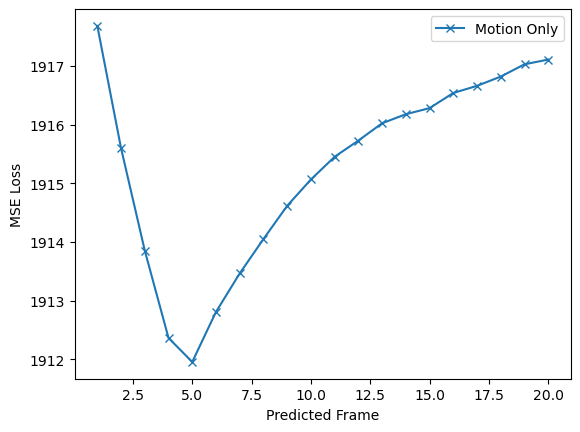

In [21]:
seq_multimodal = [1894.4669, 1899.7924, 1902.7662, 1905.1570, 1907.7374, 1910.7319, 1913.3003, 1915.0850, 1917.1271, 1918.6663]
seq_multimodal_20_epochs = [1892.7173, 1896.3646, 1900.1072, 1904.2601, 1907.5897, 1910.6614, 1913.7996, 1916.1907, 1918.3767, 1920.4690, 1922.5078, 1924.5469, 1925.6019, 1926.9579, 1927.9398, 1928.9407, 1929.6233, 1931.0037, 1930.6196, 1931.4796]
input_prediction = [3761.5696, 3766.0742, 3770.2961, 3774.6338, 3778.9668, 3782.9863, 3786.7363, 3790.2859, 3793.3655, 3796.3274]
seq_baseline_no_batch_first = [1917.681884765625, 1915.59716796875, 1913.8521728515625, 1912.363037109375, 1911.9547119140625, 1912.8072509765625, 1913.463623046875, 1914.049072265625, 1914.6158447265625, 1915.064453125, 1915.4517822265625, 1915.7275390625, 1916.0230712890625, 1916.1766357421875, 1916.2808837890625, 1916.5389404296875, 1916.6605224609375, 1916.8184814453125, 1917.02783203125, 1917.1083984375]
seq_baseline = [1917.681884765625, 1915.59716796875, 1913.8521728515625, 1912.363037109375, 1911.9547119140625, 1912.8072509765625, 1913.463623046875, 1914.049072265625, 1914.6158447265625, 1915.064453125, 1915.4517822265625, 1915.7275390625, 1916.0230712890625, 1916.1766357421875, 1916.2808837890625, 1916.5389404296875, 1916.6605224609375, 1916.8184814453125, 1917.02783203125, 1917.1083984375]
# baseline model 20 epochs with one empty vector passed to encoder 
empty = [1918.2088623046875, 1916.3565673828125, 1915.382568359375, 1913.998291015625, 1912.6492919921875, 1912.1082763671875, 1912.787841796875, 1913.3507080078125, 1913.89013671875, 1914.329833984375, 1914.685302734375, 1914.894287109375, 1915.005859375, 1915.200927734375, 1915.37255859375, 1915.4410400390625, 1915.546142578125, 1915.667236328125, 1915.8021240234375, 1915.9884033203125]
# baseline model when fixed 10 epochs 
#epoch_10 = [1918.2089, 1916.3566, 1915.3826, 1913.9983, 1912.6493, 1912.1083, 1912.7878, 1913.3507, 1913.8901, 1914.3298]
# baseline model before input not passed to decoder was fixed
#decoder_broken = [1922.4846, 1918.9752, 1917.7970, 1917.0983, 1916.5391, 1916.1447, 1916.0021, 1915.9563, 1915.9431, 1915.9354, 1915.9480, 1915.9373, 1915.9353, 1915.9379, 1915.9410, 1915.9434, 1915.9460, 1915.9475, 1915.9489, 1915.9491]

# Define the epochs or x-axis values
epochs = range(1, len(seq_multimodal) + 1)
epochs_baseline = range(1, len(seq_baseline) + 1)

# Create a plot
#plt.plot(epochs, seq_multimodal, label='Image + Motion', marker='x')
#plt.plot(epochs_baseline[:], seq_multimodal_20_epochs[:], label="Image + Motion", marker="x")
#plt.plot(epochs, input_prediction, label='Input', marker='x')
plt.plot(epochs_baseline[:], seq_baseline[:], label='Motion Only', marker='x')
#plt.plot(epochs_baseline, seq_res, label='Motion Only', marker='x')
#plt.plot(epochs_baseline, empty, label='Empty Vector', marker='x')

# Add labels, title, and legend
plt.xlabel('Predicted Frame')
plt.ylabel('MSE Loss')
#plt.title('Model Loss')
plt.legend()

# Show the plot

#plt.savefig("loss_no_input_prediction.png")
plt.show()

In [3]:
print(np.mean(seq_multimodal))

1908.48305


In [16]:
print(np.mean(seq_multimodal_20_epochs[:10]))

1908.0536300000003


[10.3561 11.0209 12.0283 12.9139 13.6713 14.3304 14.9167 15.4293 15.8918
 16.2999 16.6491 16.9683 17.2346 17.4609 17.6667 17.8612 18.0412 18.195
 18.3325 18.4477]


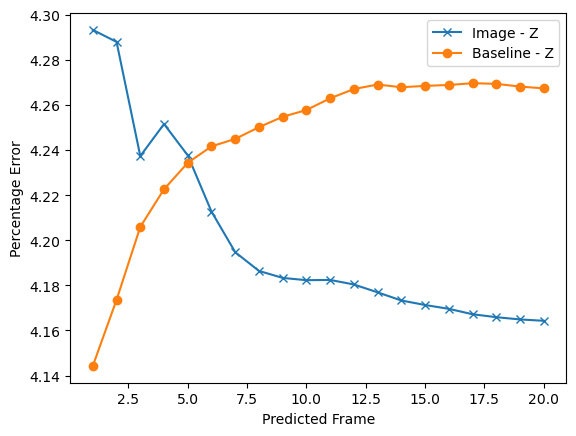

In [9]:
multimodal_acc = np.array([[10.3561, 10.8817, 4.2932, 60.0688], [11.0209, 12.2372, 4.2879, 33.8969], [12.0283, 13.1234, 4.2373, 27.8612], [12.9139, 13.7436, 4.2515, 24.5769], 
[13.6713, 14.3448, 4.2376, 28.5717], [14.3304, 14.8995, 4.2127, 38.8901], [14.9167, 15.4018, 4.1947, 44.4708], [15.4293, 15.8700, 4.1864, 47.0572], 
[15.8918, 16.3139, 4.1833, 48.0548], [16.2999, 16.7202, 4.1823, 48.2647], [16.6491, 17.0764, 4.1824, 48.1682], [16.9683, 17.4082, 4.1804, 48.0274], 
[17.2346, 17.7084, 4.1769, 47.8895], [17.4609, 17.9763, 4.1733, 47.7388], [17.6667, 18.2236, 4.1713, 47.6270], [17.8612, 18.4550, 4.1696, 47.5588], 
[18.0412, 18.6649, 4.1672, 47.4933], [18.1950, 18.8567, 4.1659, 47.3864], [18.3325, 19.0306, 4.1649, 47.3048], [18.4477, 19.1842, 4.1643, 47.2312]])

baseline_acc = np.array([[15.8247, 15.2024, 4.1443, 120.3545], [15.7754, 14.9835, 4.1736, 83.2106], [15.5475, 15.0135, 4.2059, 64.7701], [15.6383, 15.1962, 4.2226, 53.9834], [15.8193, 15.4066, 4.2343, 48.3639], [16.0766, 15.5605, 4.2416, 46.8454], [16.3731, 15.6750, 4.2449, 46.5181], [16.6423, 15.7784, 4.2501, 46.5578], [16.8549, 15.8619, 4.2547, 46.6941], [17.0138, 15.9268, 4.2577, 46.6678], [17.1422, 15.9741, 4.2629, 46.4944], [17.2603, 16.0176, 4.2670, 46.3075], [17.3725, 16.0568, 4.2690, 46.0559], [17.4818, 16.0905, 4.2678, 45.7900], [17.5887, 16.1179, 4.2684, 45.6426], [17.6920, 16.1450, 4.2688, 45.7126], [17.7972, 16.1709, 4.2696, 45.9558], [17.9061, 16.1953, 4.2693, 46.3139], [18.0070, 16.2153, 4.2681, 46.7341], [18.1091, 16.2344, 4.2673, 47.1467]])

# Define the epochs or x-axis values
epochs = range(1, len(multimodal_acc) + 1)
print(multimodal_acc[:,0])
# Create a plot
# plt.plot(epochs, multimodal_acc[:,0], label='Image - X', marker='x')
# plt.plot(epochs, multimodal_acc[:,1], label='Image - Y', marker='x')
plt.plot(epochs, multimodal_acc[:,2], label='Image - Z', marker='x')
#plt.plot(epochs, multimodal_acc[:,3], label='Image - Angle', marker='x')

# plt.plot(epochs, baseline_acc[:,0], label='Baseline - X', marker='o')
# plt.plot(epochs, baseline_acc[:,1], label='Baseline - Y', marker='o')
plt.plot(epochs, baseline_acc[:,2], label='Baseline - Z', marker='o')
#plt.plot(epochs, baseline_acc[:,3], label='Baseline - Angle', marker='o')

# Add labels, title, and legend
plt.xlabel('Predicted Frame')
plt.ylabel('Percentage Error')
#plt.title('Model Loss')
plt.legend()

# Show the plot

plt.savefig("percentage_error_z.png")
plt.show()

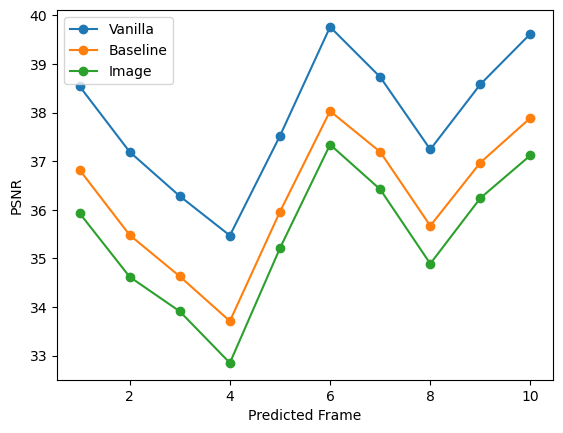

In [14]:
h264_psnr_baseline = [36.82, 35.48, 34.63, 33.71, 35.96, 38.03, 37.19, 35.67, 36.97, 37.89]
h264_psnr_vanilla = [38.54, 37.19, 36.28, 35.47, 37.52, 39.76, 38.73, 37.24, 38.58, 39.62]
h264_psnr_image = [35.93, 34.62, 33.91, 32.85, 35.21, 37.34, 36.42, 34.89, 36.24, 37.12]

# Define the epochs or x-axis values
epochs = range(1, len(h264_psnr_baseline) + 1)
# Create a plot
plt.plot(epochs, h264_psnr_vanilla, label='Vanilla', marker='o')
plt.plot(epochs,h264_psnr_baseline, label='Baseline', marker='o')
plt.plot(epochs, h264_psnr_image, label='Image', marker='o')


# Add labels, title, and legend
plt.xlabel('Predicted Frame')
plt.ylabel('PSNR')
#plt.title('Model Loss')
plt.legend()

# Show the plot

plt.savefig("h264_psnr.png")
plt.show()

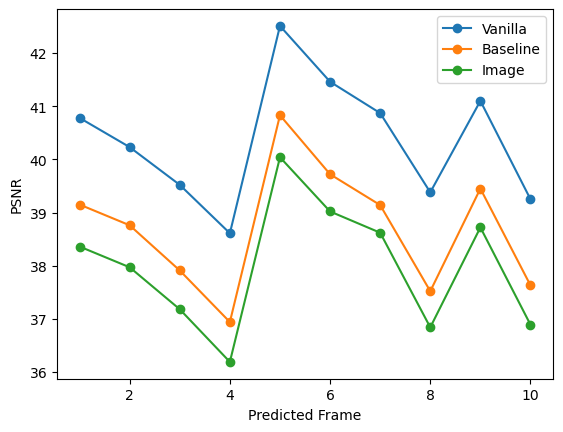

In [15]:
h265_psnr_baseline = [39.15, 38.76, 37.91, 36.94, 40.83, 39.72, 39.14, 37.52, 39.45, 37.63]
h265_psnr_vanilla = [40.78, 40.23, 39.52, 38.61, 42.51, 41.46, 40.87, 39.38, 41.10, 39.25]
h265_psnr_image = [38.36, 37.97, 37.18, 36.19, 40.04, 39.02, 38.62, 36.84, 38.72, 36.89]

# Define the epochs or x-axis values
epochs = range(1, len(h265_psnr_baseline) + 1)
# Create a plot
plt.plot(epochs, h265_psnr_vanilla, label='Vanilla', marker='o')
plt.plot(epochs,h265_psnr_baseline, label='Baseline', marker='o')
plt.plot(epochs, h265_psnr_image, label='Image', marker='o')


# Add labels, title, and legend
plt.xlabel('Predicted Frame')
plt.ylabel('PSNR')
#plt.title('Model Loss')
plt.legend()

# Show the plot

plt.savefig("h265_psnr.png")
plt.show()

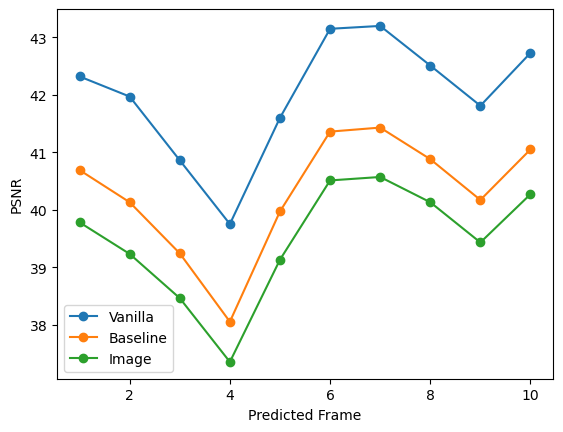

In [16]:
av1_psnr_baseline = [40.69, 40.13, 39.24, 38.05, 39.97, 41.36, 41.43, 40.88, 40.17, 41.05]
av1_psnr_vanilla = [42.32, 41.97, 40.86, 39.75, 41.60, 43.15, 43.20, 42.51, 41.81, 42.73]
av1_psnr_image = [39.78, 39.23, 38.46, 37.35, 39.13, 40.51, 40.57, 40.13, 39.43, 40.27]

# Define the epochs or x-axis values
epochs = range(1, len(av1_psnr_baseline) + 1)
# Create a plot
plt.plot(epochs, av1_psnr_vanilla, label='Vanilla', marker='o')
plt.plot(epochs,av1_psnr_baseline, label='Baseline', marker='o')
plt.plot(epochs, av1_psnr_image, label='Image', marker='o')


# Add labels, title, and legend
plt.xlabel('Predicted Frame')
plt.ylabel('PSNR')
#plt.title('Model Loss')
plt.legend()

# Show the plot

plt.savefig("av1_psnr.png")
plt.show()

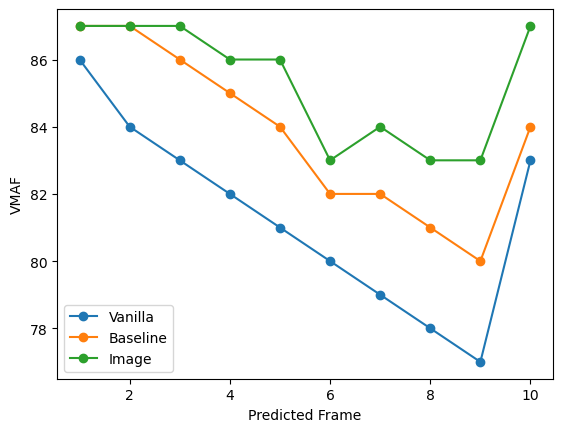

In [9]:
h264_vmaf_baseline = [87, 87, 86, 85, 84, 82, 82, 81, 80, 84]
h264_vmaf_vanilla = [86, 84, 83, 82, 81, 80, 79, 78, 77, 83]
h264_vmaf_image = [87, 87, 87, 86, 86, 83, 84, 83, 83, 87]

# Define the epochs or x-axis values
epochs = range(1, len(h264_vmaf_baseline) + 1)
# Create a plot
plt.plot(epochs, h264_vmaf_vanilla, label='Vanilla', marker='o')
plt.plot(epochs,h264_vmaf_baseline, label='Baseline', marker='o')
plt.plot(epochs, h264_vmaf_image, label='Image', marker='o')


# Add labels, title, and legend
plt.xlabel('Predicted Frame')
plt.ylabel('VMAF')
#plt.title('Model Loss')
plt.legend()

# Show the plot

#plt.savefig("percentage_error_z.png")
plt.show()

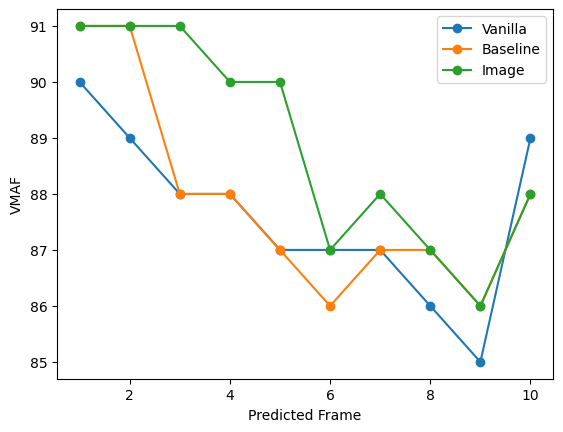

In [11]:
h265_vmaf_baseline = [91, 91, 88, 88, 87, 86, 87, 87, 86, 88]
h265_vmaf_vanilla = [90, 89, 88, 88, 87, 87, 87, 86, 85, 89]
h265_vmaf_image = [91, 91, 91, 90, 90, 87, 88, 87, 86, 88]

# Define the epochs or x-axis values
epochs = range(1, len(h265_vmaf_baseline) + 1)
# Create a plot
plt.plot(epochs, h265_vmaf_vanilla, label='Vanilla', marker='o')
plt.plot(epochs,h265_vmaf_baseline, label='Baseline', marker='o')
plt.plot(epochs, h265_vmaf_image, label='Image', marker='o')


# Add labels, title, and legend
plt.xlabel('Predicted Frame')
plt.ylabel('VMAF')
#plt.title('Model Loss')
plt.legend()

# Show the plot

#plt.savefig("percentage_error_z.png")
plt.show()

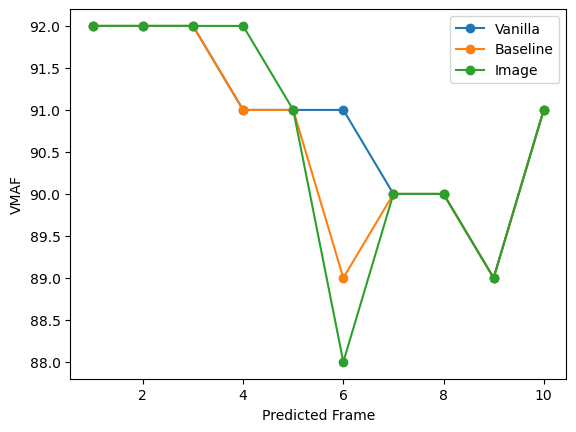

In [13]:
av1_vmaf_baseline = [92, 92, 92, 91, 91, 89, 90, 90, 89, 91]
av1_vmaf_vanilla = [92, 92, 92, 91, 91, 91, 90, 90, 89, 91]
av1_vmaf_image = [92, 92, 92, 92, 91, 88, 90, 90, 89, 91]

# Define the epochs or x-axis values
epochs = range(1, len(av1_vmaf_baseline) + 1)
# Create a plot
plt.plot(epochs, av1_vmaf_vanilla, label='Vanilla', marker='o')
plt.plot(epochs,av1_vmaf_baseline, label='Baseline', marker='o')
plt.plot(epochs, av1_vmaf_image, label='Image', marker='o')


# Add labels, title, and legend
plt.xlabel('Predicted Frame')
plt.ylabel('VMAF')
#plt.title('Model Loss')
plt.legend()

# Show the plot

#plt.savefig("percentage_error_z.png")
plt.show()